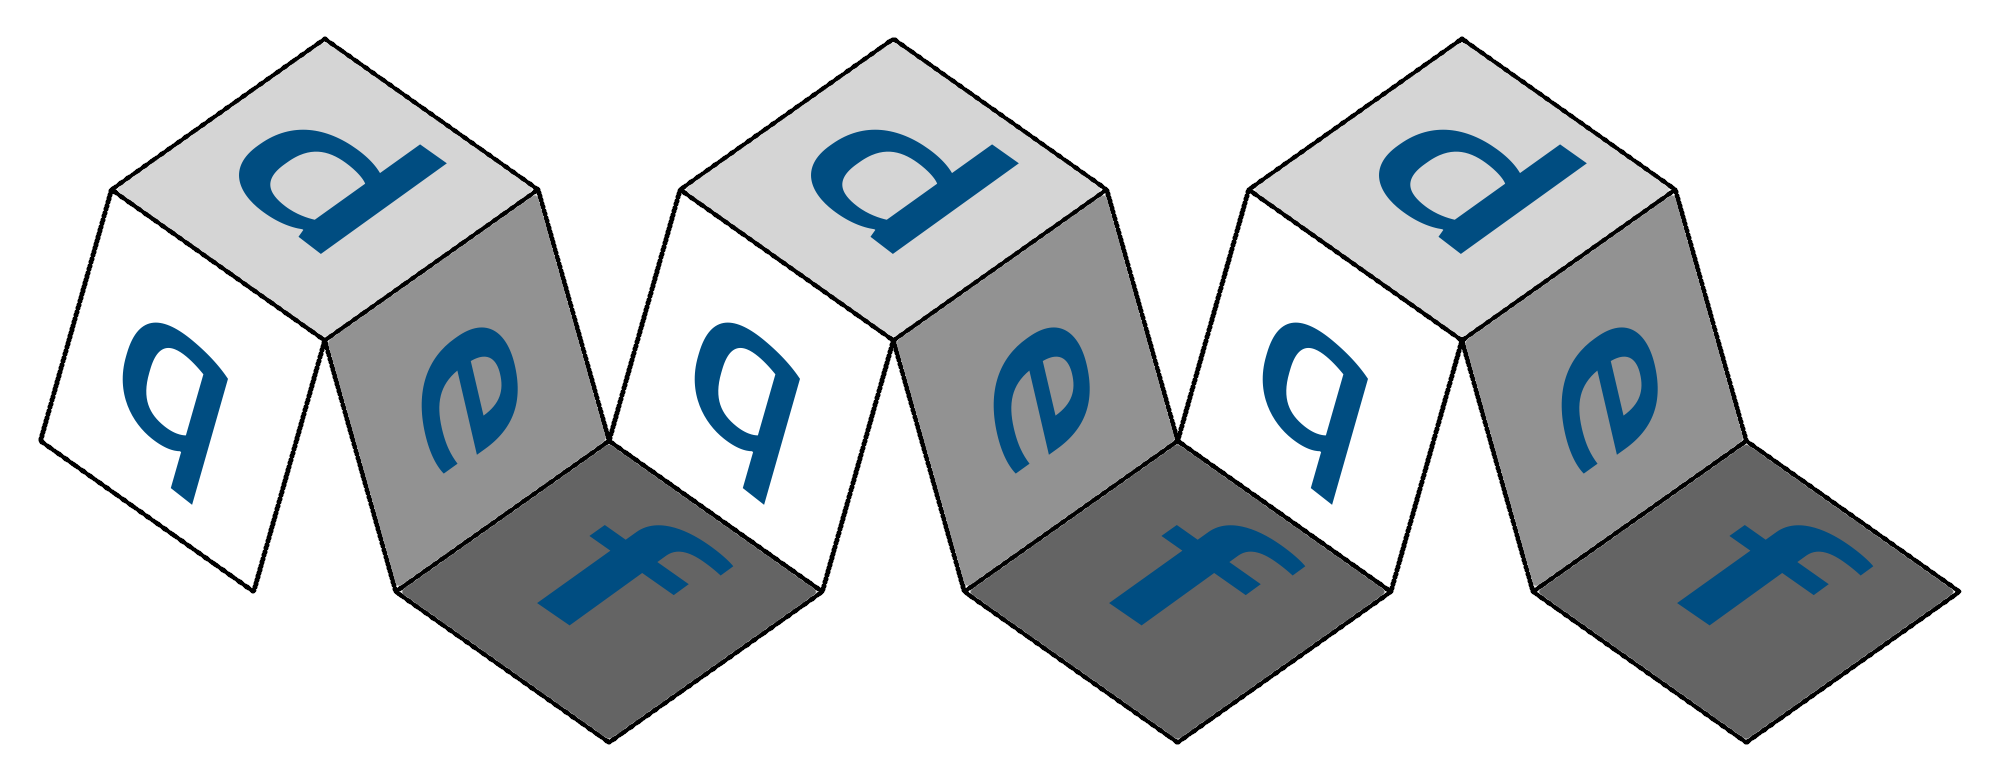

In [2033]:
%load_ext autoreload
%autoreload 2
import sympy
import numpy as np
# from sympy.functions.special.spherical_harmonics import Ynm as Ynm_sym
from sympy import Symbol, pi, sqrt, Sum, simplify, Rational, Q, refine
from scipy.special import sph_harm as Ynm_num
from sympy import poly, lambdify
from IPython.display import display, Math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sympy import diff, factorial, poly, symbols, latex
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False
from qdefvstsk import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import HTML, display, Math, Latex

# Defining kets, bras, and brakets

A Qet is defined by a dictionary whose keys are tuples, and whose values are coefficients.

For example the Bell basis may be defined in the following way.

In [24]:
bell_basis = [Qet({(0,0):S(1)/sqrt(2),
            (1,1):S(1)/sqrt(2)}),
       Qet({(0,0):S(1)/sqrt(2),
            (1,1):-S(1)/sqrt(2)}),
       Qet({(1,0):S(1)/sqrt(2),
            (0,1):S(1)/sqrt(2)}),
       Qet({(0,1):S(1)/sqrt(2),
            (1,0):-S(1)/sqrt(2)})
       ]
for qet in bell_basis:
  display(qet.as_ket(True))

sqrt(2)*|00>/2 + sqrt(2)*|11>/2

sqrt(2)*|00>/2 - sqrt(2)*|11>/2

sqrt(2)*|01>/2 + sqrt(2)*|10>/2

sqrt(2)*|01>/2 - sqrt(2)*|10>/2

And if this type of basis is used for the Hilbert space of four qubits, one may then produce the resulting basis: 

In [25]:
bigger_basis = []
for qet in bell_basis:
  new_qets = [q*qet for q in bell_basis]
  bigger_basis.extend(new_qets)
  for n_qet in new_qets:
    display(n_qet.as_ket(True))

|0000>/2 + |0011>/2 + |1100>/2 + |1111>/2

|0000>/2 + |0011>/2 - |1100>/2 - |1111>/2

|0100>/2 + |0111>/2 + |1000>/2 + |1011>/2

|0100>/2 + |0111>/2 - |1000>/2 - |1011>/2

|0000>/2 - |0011>/2 + |1100>/2 - |1111>/2

|0000>/2 - |0011>/2 - |1100>/2 + |1111>/2

|0100>/2 - |0111>/2 + |1000>/2 - |1011>/2

|0100>/2 - |0111>/2 - |1000>/2 + |1011>/2

|0001>/2 + |0010>/2 + |1101>/2 + |1110>/2

|0001>/2 + |0010>/2 - |1101>/2 - |1110>/2

|0101>/2 + |0110>/2 + |1001>/2 + |1010>/2

|0101>/2 + |0110>/2 - |1001>/2 - |1010>/2

|0001>/2 - |0010>/2 + |1101>/2 - |1110>/2

|0001>/2 - |0010>/2 - |1101>/2 + |1110>/2

|0101>/2 - |0110>/2 + |1001>/2 - |1010>/2

|0101>/2 - |0110>/2 - |1001>/2 + |1010>/2

We might as well find the transformation of the standard basis that corresponds to the set given above. And confirm that it is a unitary transformation.

In [26]:
basis = list(product((0,1),(0,1),(0,1),(0,1)))

In [27]:
t_matrix = Matrix([ket.vec_in_basis(basis) for ket in bigger_basis]).T

In [28]:
t_matrix

Matrix([
[1/2,  1/2,   0,    0,  1/2,  1/2,    0,    0,   0,    0,   0,    0,    0,    0,    0,    0],
[  0,    0,   0,    0,    0,    0,    0,    0, 1/2,  1/2,   0,    0,  1/2,  1/2,    0,    0],
[  0,    0,   0,    0,    0,    0,    0,    0, 1/2,  1/2,   0,    0, -1/2, -1/2,    0,    0],
[1/2,  1/2,   0,    0, -1/2, -1/2,    0,    0,   0,    0,   0,    0,    0,    0,    0,    0],
[  0,    0, 1/2,  1/2,    0,    0,  1/2,  1/2,   0,    0,   0,    0,    0,    0,    0,    0],
[  0,    0,   0,    0,    0,    0,    0,    0,   0,    0, 1/2,  1/2,    0,    0,  1/2,  1/2],
[  0,    0,   0,    0,    0,    0,    0,    0,   0,    0, 1/2,  1/2,    0,    0, -1/2, -1/2],
[  0,    0, 1/2,  1/2,    0,    0, -1/2, -1/2,   0,    0,   0,    0,    0,    0,    0,    0],
[  0,    0, 1/2, -1/2,    0,    0,  1/2, -1/2,   0,    0,   0,    0,    0,    0,    0,    0],
[  0,    0,   0,    0,    0,    0,    0,    0,   0,    0, 1/2, -1/2,    0,    0,  1/2, -1/2],
[  0,    0,   0,    0,    0,    0,    0,    0,   0,

In [259]:
# let's check that this matrix is orthogonal
t_matrix*t_matrix.T == eye(16)

True

In [410]:
Math(r'\bar{%s}' % latex(1))

<IPython.core.display.Math object>

In [2023]:
for k in all_spharms_normal['C_s']:
  if k < 4:
    continue
  for qet in all_spharms_normal['C_s'][k]:
    display(Qet(qet).as_ket(True,True))

|40>

sqrt(2)*|42>/2 + sqrt(2)*|4\bar{2}>/2

sqrt(2)*I*|42>/2 - sqrt(2)*I*|4\bar{2}>/2

sqrt(2)*|44>/2 + sqrt(2)*|4\bar{4}>/2

sqrt(2)*I*|44>/2 - sqrt(2)*I*|4\bar{4}>/2

sqrt(2)*I*|51>/2 + sqrt(2)*I*|5\bar{1}>/2

sqrt(2)*|51>/2 - sqrt(2)*|5\bar{1}>/2

sqrt(2)*I*|53>/2 + sqrt(2)*I*|5\bar{3}>/2

sqrt(2)*|53>/2 - sqrt(2)*|5\bar{3}>/2

sqrt(2)*I*|55>/2 + sqrt(2)*I*|5\bar{5}>/2

sqrt(2)*|55>/2 - sqrt(2)*|5\bar{5}>/2

|60>

sqrt(2)*|62>/2 + sqrt(2)*|6\bar{2}>/2

sqrt(2)*I*|62>/2 - sqrt(2)*I*|6\bar{2}>/2

sqrt(2)*|64>/2 + sqrt(2)*|6\bar{4}>/2

sqrt(2)*I*|64>/2 - sqrt(2)*I*|6\bar{4}>/2

sqrt(2)*|66>/2 + sqrt(2)*|6\bar{6}>/2

sqrt(2)*I*|66>/2 - sqrt(2)*I*|6\bar{6}>/2

sqrt(2)*I*|71>/2 + sqrt(2)*I*|7\bar{1}>/2

sqrt(2)*|71>/2 - sqrt(2)*|7\bar{1}>/2

sqrt(2)*I*|73>/2 + sqrt(2)*I*|7\bar{3}>/2

sqrt(2)*|73>/2 - sqrt(2)*|7\bar{3}>/2

sqrt(2)*I*|75>/2 + sqrt(2)*I*|7\bar{5}>/2

sqrt(2)*|75>/2 - sqrt(2)*|7\bar{5}>/2

sqrt(2)*I*|77>/2 + sqrt(2)*I*|7\bar{7}>/2

sqrt(2)*|77>/2 - sqrt(2)*|7\bar{7}>/2

|80>

sqrt(2)*|88>/2 + sqrt(2)*|8\bar{8}>/2

sqrt(2)*I*|88>/2 - sqrt(2)*I*|8\bar{8}>/2

sqrt(2)*|82>/2 + sqrt(2)*|8\bar{2}>/2

sqrt(2)*I*|82>/2 - sqrt(2)*I*|8\bar{2}>/2

sqrt(2)*|84>/2 + sqrt(2)*|8\bar{4}>/2

sqrt(2)*I*|84>/2 - sqrt(2)*I*|8\bar{4}>/2

sqrt(2)*|86>/2 + sqrt(2)*|8\bar{6}>/2

sqrt(2)*I*|86>/2 - sqrt(2)*I*|8\bar{6}>/2

sqrt(2)*I*|91>/2 + sqrt(2)*I*|9\bar{1}>/2

sqrt(2)*|91>/2 - sqrt(2)*|9\bar{1}>/2

sqrt(2)*I*|93>/2 + sqrt(2)*I*|9\bar{3}>/2

sqrt(2)*|93>/2 - sqrt(2)*|9\bar{3}>/2

sqrt(2)*I*|95>/2 + sqrt(2)*I*|9\bar{5}>/2

sqrt(2)*|95>/2 - sqrt(2)*|9\bar{5}>/2

sqrt(2)*I*|97>/2 + sqrt(2)*I*|9\bar{7}>/2

sqrt(2)*|97>/2 - sqrt(2)*|9\bar{7}>/2

sqrt(2)*I*|99>/2 + sqrt(2)*I*|9\bar{9}>/2

sqrt(2)*|99>/2 - sqrt(2)*|9\bar{9}>/2

|100>

sqrt(2)*|102>/2 + sqrt(2)*|10\bar{2}>/2

sqrt(2)*I*|102>/2 - sqrt(2)*I*|10\bar{2}>/2

sqrt(2)*|104>/2 + sqrt(2)*|10\bar{4}>/2

sqrt(2)*I*|104>/2 - sqrt(2)*I*|10\bar{4}>/2

sqrt(2)*|106>/2 + sqrt(2)*|10\bar{6}>/2

sqrt(2)*I*|106>/2 - sqrt(2)*I*|10\bar{6}>/2

sqrt(2)*|108>/2 + sqrt(2)*|10\bar{8}>/2

sqrt(2)*I*|108>/2 - sqrt(2)*I*|10\bar{8}>/2

sqrt(2)*|1010>/2 + sqrt(2)*|10\bar{10}>/2

sqrt(2)*I*|1010>/2 - sqrt(2)*I*|10\bar{10}>/2

sqrt(2)*I*|111>/2 + sqrt(2)*I*|11\bar{1}>/2

sqrt(2)*|111>/2 - sqrt(2)*|11\bar{1}>/2

sqrt(2)*I*|113>/2 + sqrt(2)*I*|11\bar{3}>/2

sqrt(2)*|113>/2 - sqrt(2)*|11\bar{3}>/2

sqrt(2)*I*|115>/2 + sqrt(2)*I*|11\bar{5}>/2

sqrt(2)*|115>/2 - sqrt(2)*|11\bar{5}>/2

sqrt(2)*I*|117>/2 + sqrt(2)*I*|11\bar{7}>/2

sqrt(2)*|117>/2 - sqrt(2)*|11\bar{7}>/2

sqrt(2)*I*|119>/2 + sqrt(2)*I*|11\bar{9}>/2

sqrt(2)*|119>/2 - sqrt(2)*|11\bar{9}>/2

sqrt(2)*I*|1111>/2 + sqrt(2)*I*|11\bar{11}>/2

sqrt(2)*|1111>/2 - sqrt(2)*|11\bar{11}>/2

|120>

sqrt(2)*|122>/2 + sqrt(2)*|12\bar{2}>/2

sqrt(2)*I*|122>/2 - sqrt(2)*I*|12\bar{2}>/2

sqrt(2)*|124>/2 + sqrt(2)*|12\bar{4}>/2

sqrt(2)*I*|124>/2 - sqrt(2)*I*|12\bar{4}>/2

sqrt(2)*|126>/2 + sqrt(2)*|12\bar{6}>/2

sqrt(2)*I*|126>/2 - sqrt(2)*I*|12\bar{6}>/2

sqrt(2)*|128>/2 + sqrt(2)*|12\bar{8}>/2

sqrt(2)*I*|128>/2 - sqrt(2)*I*|12\bar{8}>/2

sqrt(2)*|1210>/2 + sqrt(2)*|12\bar{10}>/2

sqrt(2)*I*|1210>/2 - sqrt(2)*I*|12\bar{10}>/2

sqrt(2)*|1212>/2 + sqrt(2)*|12\bar{12}>/2

sqrt(2)*I*|1212>/2 - sqrt(2)*I*|12\bar{12}>/2

sqrt(2)*I*|131>/2 + sqrt(2)*I*|13\bar{1}>/2

sqrt(2)*|131>/2 - sqrt(2)*|13\bar{1}>/2

sqrt(2)*I*|133>/2 + sqrt(2)*I*|13\bar{3}>/2

sqrt(2)*|133>/2 - sqrt(2)*|13\bar{3}>/2

sqrt(2)*I*|135>/2 + sqrt(2)*I*|13\bar{5}>/2

sqrt(2)*|135>/2 - sqrt(2)*|13\bar{5}>/2

sqrt(2)*I*|137>/2 + sqrt(2)*I*|13\bar{7}>/2

sqrt(2)*|137>/2 - sqrt(2)*|13\bar{7}>/2

sqrt(2)*I*|139>/2 + sqrt(2)*I*|13\bar{9}>/2

sqrt(2)*|139>/2 - sqrt(2)*|13\bar{9}>/2

sqrt(2)*I*|1311>/2 + sqrt(2)*I*|13\bar{11}>/2

sqrt(2)*|1311>/2 - sqrt(2)*|13\bar{11}>/2

sqrt(2)*I*|1313>/2 + sqrt(2)*I*|13\bar{13}>/2

sqrt(2)*|1313>/2 - sqrt(2)*|13\bar{13}>/2

|140>

sqrt(2)*|142>/2 + sqrt(2)*|14\bar{2}>/2

sqrt(2)*I*|142>/2 - sqrt(2)*I*|14\bar{2}>/2

sqrt(2)*|144>/2 + sqrt(2)*|14\bar{4}>/2

sqrt(2)*I*|144>/2 - sqrt(2)*I*|14\bar{4}>/2

sqrt(2)*|146>/2 + sqrt(2)*|14\bar{6}>/2

sqrt(2)*I*|146>/2 - sqrt(2)*I*|14\bar{6}>/2

sqrt(2)*|148>/2 + sqrt(2)*|14\bar{8}>/2

sqrt(2)*I*|148>/2 - sqrt(2)*I*|14\bar{8}>/2

sqrt(2)*|1410>/2 + sqrt(2)*|14\bar{10}>/2

sqrt(2)*I*|1410>/2 - sqrt(2)*I*|14\bar{10}>/2

sqrt(2)*|1412>/2 + sqrt(2)*|14\bar{12}>/2

sqrt(2)*I*|1412>/2 - sqrt(2)*I*|14\bar{12}>/2

sqrt(2)*|1414>/2 + sqrt(2)*|14\bar{14}>/2

sqrt(2)*I*|1414>/2 - sqrt(2)*I*|14\bar{14}>/2

sqrt(2)*I*|151>/2 + sqrt(2)*I*|15\bar{1}>/2

sqrt(2)*|151>/2 - sqrt(2)*|15\bar{1}>/2

sqrt(2)*I*|153>/2 + sqrt(2)*I*|15\bar{3}>/2

sqrt(2)*|153>/2 - sqrt(2)*|15\bar{3}>/2

sqrt(2)*I*|155>/2 + sqrt(2)*I*|15\bar{5}>/2

sqrt(2)*|155>/2 - sqrt(2)*|15\bar{5}>/2

sqrt(2)*I*|157>/2 + sqrt(2)*I*|15\bar{7}>/2

sqrt(2)*|157>/2 - sqrt(2)*|15\bar{7}>/2

sqrt(2)*I*|159>/2 + sqrt(2)*I*|15\bar{9}>/2

sqrt(2)*|159>/2 - sqrt(2)*|15\bar{9}>/2

sqrt(2)*I*|1511>/2 + sqrt(2)*I*|15\bar{11}>/2

sqrt(2)*|1511>/2 - sqrt(2)*|15\bar{11}>/2

sqrt(2)*I*|1513>/2 + sqrt(2)*I*|15\bar{13}>/2

sqrt(2)*|1513>/2 - sqrt(2)*|15\bar{13}>/2

sqrt(2)*I*|1515>/2 + sqrt(2)*I*|15\bar{15}>/2

sqrt(2)*|1515>/2 - sqrt(2)*|15\bar{15}>/2

|160>

sqrt(2)*|162>/2 + sqrt(2)*|16\bar{2}>/2

sqrt(2)*I*|162>/2 - sqrt(2)*I*|16\bar{2}>/2

sqrt(2)*|164>/2 + sqrt(2)*|16\bar{4}>/2

sqrt(2)*I*|164>/2 - sqrt(2)*I*|16\bar{4}>/2

sqrt(2)*|166>/2 + sqrt(2)*|16\bar{6}>/2

sqrt(2)*I*|166>/2 - sqrt(2)*I*|16\bar{6}>/2

sqrt(2)*|168>/2 + sqrt(2)*|16\bar{8}>/2

sqrt(2)*I*|168>/2 - sqrt(2)*I*|16\bar{8}>/2

sqrt(2)*|1610>/2 + sqrt(2)*|16\bar{10}>/2

sqrt(2)*I*|1610>/2 - sqrt(2)*I*|16\bar{10}>/2

sqrt(2)*|1612>/2 + sqrt(2)*|16\bar{12}>/2

sqrt(2)*I*|1612>/2 - sqrt(2)*I*|16\bar{12}>/2

sqrt(2)*|1614>/2 + sqrt(2)*|16\bar{14}>/2

sqrt(2)*I*|1614>/2 - sqrt(2)*I*|16\bar{14}>/2

sqrt(2)*|1616>/2 + sqrt(2)*|16\bar{16}>/2

sqrt(2)*I*|1616>/2 - sqrt(2)*I*|16\bar{16}>/2

sqrt(2)*I*|171>/2 + sqrt(2)*I*|17\bar{1}>/2

sqrt(2)*|171>/2 - sqrt(2)*|17\bar{1}>/2

sqrt(2)*I*|173>/2 + sqrt(2)*I*|17\bar{3}>/2

sqrt(2)*|173>/2 - sqrt(2)*|17\bar{3}>/2

sqrt(2)*I*|175>/2 + sqrt(2)*I*|17\bar{5}>/2

sqrt(2)*|175>/2 - sqrt(2)*|17\bar{5}>/2

sqrt(2)*I*|177>/2 + sqrt(2)*I*|17\bar{7}>/2

sqrt(2)*|177>/2 - sqrt(2)*|17\bar{7}>/2

sqrt(2)*I*|179>/2 + sqrt(2)*I*|17\bar{9}>/2

sqrt(2)*|179>/2 - sqrt(2)*|17\bar{9}>/2

sqrt(2)*I*|1711>/2 + sqrt(2)*I*|17\bar{11}>/2

sqrt(2)*|1711>/2 - sqrt(2)*|17\bar{11}>/2

sqrt(2)*I*|1713>/2 + sqrt(2)*I*|17\bar{13}>/2

sqrt(2)*|1713>/2 - sqrt(2)*|17\bar{13}>/2

sqrt(2)*I*|1715>/2 + sqrt(2)*I*|17\bar{15}>/2

sqrt(2)*|1715>/2 - sqrt(2)*|17\bar{15}>/2

sqrt(2)*I*|1717>/2 + sqrt(2)*I*|17\bar{17}>/2

sqrt(2)*|1717>/2 - sqrt(2)*|17\bar{17}>/2

|180>

sqrt(2)*|182>/2 + sqrt(2)*|18\bar{2}>/2

sqrt(2)*I*|182>/2 - sqrt(2)*I*|18\bar{2}>/2

sqrt(2)*|184>/2 + sqrt(2)*|18\bar{4}>/2

sqrt(2)*I*|184>/2 - sqrt(2)*I*|18\bar{4}>/2

sqrt(2)*|186>/2 + sqrt(2)*|18\bar{6}>/2

sqrt(2)*I*|186>/2 - sqrt(2)*I*|18\bar{6}>/2

sqrt(2)*|188>/2 + sqrt(2)*|18\bar{8}>/2

sqrt(2)*I*|188>/2 - sqrt(2)*I*|18\bar{8}>/2

sqrt(2)*|1810>/2 + sqrt(2)*|18\bar{10}>/2

sqrt(2)*I*|1810>/2 - sqrt(2)*I*|18\bar{10}>/2

sqrt(2)*|1812>/2 + sqrt(2)*|18\bar{12}>/2

sqrt(2)*I*|1812>/2 - sqrt(2)*I*|18\bar{12}>/2

sqrt(2)*|1814>/2 + sqrt(2)*|18\bar{14}>/2

sqrt(2)*I*|1814>/2 - sqrt(2)*I*|18\bar{14}>/2

sqrt(2)*|1816>/2 + sqrt(2)*|18\bar{16}>/2

sqrt(2)*I*|1816>/2 - sqrt(2)*I*|18\bar{16}>/2

sqrt(2)*|1818>/2 + sqrt(2)*|18\bar{18}>/2

sqrt(2)*I*|1818>/2 - sqrt(2)*I*|18\bar{18}>/2

sqrt(2)*I*|191>/2 + sqrt(2)*I*|19\bar{1}>/2

sqrt(2)*|191>/2 - sqrt(2)*|19\bar{1}>/2

sqrt(2)*I*|193>/2 + sqrt(2)*I*|19\bar{3}>/2

sqrt(2)*|193>/2 - sqrt(2)*|19\bar{3}>/2

sqrt(2)*I*|195>/2 + sqrt(2)*I*|19\bar{5}>/2

sqrt(2)*|195>/2 - sqrt(2)*|19\bar{5}>/2

sqrt(2)*I*|197>/2 + sqrt(2)*I*|19\bar{7}>/2

sqrt(2)*|197>/2 - sqrt(2)*|19\bar{7}>/2

sqrt(2)*I*|199>/2 + sqrt(2)*I*|19\bar{9}>/2

sqrt(2)*|199>/2 - sqrt(2)*|19\bar{9}>/2

sqrt(2)*I*|1911>/2 + sqrt(2)*I*|19\bar{11}>/2

sqrt(2)*|1911>/2 - sqrt(2)*|19\bar{11}>/2

sqrt(2)*I*|1913>/2 + sqrt(2)*I*|19\bar{13}>/2

sqrt(2)*|1913>/2 - sqrt(2)*|19\bar{13}>/2

sqrt(2)*I*|1915>/2 + sqrt(2)*I*|19\bar{15}>/2

sqrt(2)*|1915>/2 - sqrt(2)*|19\bar{15}>/2

sqrt(2)*I*|1917>/2 + sqrt(2)*I*|19\bar{17}>/2

sqrt(2)*|1917>/2 - sqrt(2)*|19\bar{17}>/2

sqrt(2)*I*|1919>/2 + sqrt(2)*I*|19\bar{19}>/2

sqrt(2)*|1919>/2 - sqrt(2)*|19\bar{19}>/2

|200>

sqrt(2)*|202>/2 + sqrt(2)*|20\bar{2}>/2

sqrt(2)*I*|202>/2 - sqrt(2)*I*|20\bar{2}>/2

sqrt(2)*|204>/2 + sqrt(2)*|20\bar{4}>/2

sqrt(2)*I*|204>/2 - sqrt(2)*I*|20\bar{4}>/2

sqrt(2)*|206>/2 + sqrt(2)*|20\bar{6}>/2

sqrt(2)*I*|206>/2 - sqrt(2)*I*|20\bar{6}>/2

sqrt(2)*|208>/2 + sqrt(2)*|20\bar{8}>/2

sqrt(2)*I*|208>/2 - sqrt(2)*I*|20\bar{8}>/2

sqrt(2)*|2010>/2 + sqrt(2)*|20\bar{10}>/2

sqrt(2)*I*|2010>/2 - sqrt(2)*I*|20\bar{10}>/2

sqrt(2)*|2012>/2 + sqrt(2)*|20\bar{12}>/2

sqrt(2)*I*|2012>/2 - sqrt(2)*I*|20\bar{12}>/2

sqrt(2)*|2014>/2 + sqrt(2)*|20\bar{14}>/2

sqrt(2)*I*|2014>/2 - sqrt(2)*I*|20\bar{14}>/2

sqrt(2)*|2016>/2 + sqrt(2)*|20\bar{16}>/2

sqrt(2)*I*|2016>/2 - sqrt(2)*I*|20\bar{16}>/2

sqrt(2)*|2018>/2 + sqrt(2)*|20\bar{18}>/2

sqrt(2)*I*|2018>/2 - sqrt(2)*I*|20\bar{18}>/2

sqrt(2)*|2020>/2 + sqrt(2)*|20\bar{20}>/2

sqrt(2)*I*|2020>/2 - sqrt(2)*I*|20\bar{20}>/2

sqrt(2)*I*|211>/2 + sqrt(2)*I*|21\bar{1}>/2

sqrt(2)*|211>/2 - sqrt(2)*|21\bar{1}>/2

sqrt(2)*I*|213>/2 + sqrt(2)*I*|21\bar{3}>/2

sqrt(2)*|213>/2 - sqrt(2)*|21\bar{3}>/2

sqrt(2)*I*|215>/2 + sqrt(2)*I*|21\bar{5}>/2

sqrt(2)*|215>/2 - sqrt(2)*|21\bar{5}>/2

sqrt(2)*I*|217>/2 + sqrt(2)*I*|21\bar{7}>/2

sqrt(2)*|217>/2 - sqrt(2)*|21\bar{7}>/2

sqrt(2)*I*|219>/2 + sqrt(2)*I*|21\bar{9}>/2

sqrt(2)*|219>/2 - sqrt(2)*|21\bar{9}>/2

sqrt(2)*I*|2111>/2 + sqrt(2)*I*|21\bar{11}>/2

sqrt(2)*|2111>/2 - sqrt(2)*|21\bar{11}>/2

sqrt(2)*I*|2113>/2 + sqrt(2)*I*|21\bar{13}>/2

sqrt(2)*|2113>/2 - sqrt(2)*|21\bar{13}>/2

sqrt(2)*I*|2115>/2 + sqrt(2)*I*|21\bar{15}>/2

sqrt(2)*|2115>/2 - sqrt(2)*|21\bar{15}>/2

sqrt(2)*I*|2117>/2 + sqrt(2)*I*|21\bar{17}>/2

sqrt(2)*|2117>/2 - sqrt(2)*|21\bar{17}>/2

sqrt(2)*I*|2119>/2 + sqrt(2)*I*|21\bar{19}>/2

sqrt(2)*|2119>/2 - sqrt(2)*|21\bar{19}>/2

sqrt(2)*I*|2121>/2 + sqrt(2)*I*|21\bar{21}>/2

sqrt(2)*|2121>/2 - sqrt(2)*|21\bar{21}>/2

|220>

sqrt(2)*|222>/2 + sqrt(2)*|22\bar{2}>/2

sqrt(2)*I*|222>/2 - sqrt(2)*I*|22\bar{2}>/2

sqrt(2)*|224>/2 + sqrt(2)*|22\bar{4}>/2

sqrt(2)*I*|224>/2 - sqrt(2)*I*|22\bar{4}>/2

sqrt(2)*|226>/2 + sqrt(2)*|22\bar{6}>/2

sqrt(2)*I*|226>/2 - sqrt(2)*I*|22\bar{6}>/2

sqrt(2)*|228>/2 + sqrt(2)*|22\bar{8}>/2

sqrt(2)*I*|228>/2 - sqrt(2)*I*|22\bar{8}>/2

sqrt(2)*|2210>/2 + sqrt(2)*|22\bar{10}>/2

sqrt(2)*I*|2210>/2 - sqrt(2)*I*|22\bar{10}>/2

sqrt(2)*|2212>/2 + sqrt(2)*|22\bar{12}>/2

sqrt(2)*I*|2212>/2 - sqrt(2)*I*|22\bar{12}>/2

sqrt(2)*|2214>/2 + sqrt(2)*|22\bar{14}>/2

sqrt(2)*I*|2214>/2 - sqrt(2)*I*|22\bar{14}>/2

sqrt(2)*|2216>/2 + sqrt(2)*|22\bar{16}>/2

sqrt(2)*I*|2216>/2 - sqrt(2)*I*|22\bar{16}>/2

sqrt(2)*|2218>/2 + sqrt(2)*|22\bar{18}>/2

sqrt(2)*I*|2218>/2 - sqrt(2)*I*|22\bar{18}>/2

sqrt(2)*|2220>/2 + sqrt(2)*|22\bar{20}>/2

sqrt(2)*I*|2220>/2 - sqrt(2)*I*|22\bar{20}>/2

sqrt(2)*|2222>/2 + sqrt(2)*|22\bar{22}>/2

sqrt(2)*I*|2222>/2 - sqrt(2)*I*|22\bar{22}>/2

sqrt(2)*I*|231>/2 + sqrt(2)*I*|23\bar{1}>/2

sqrt(2)*|231>/2 - sqrt(2)*|23\bar{1}>/2

sqrt(2)*I*|233>/2 + sqrt(2)*I*|23\bar{3}>/2

sqrt(2)*|233>/2 - sqrt(2)*|23\bar{3}>/2

sqrt(2)*I*|235>/2 + sqrt(2)*I*|23\bar{5}>/2

sqrt(2)*|235>/2 - sqrt(2)*|23\bar{5}>/2

sqrt(2)*I*|237>/2 + sqrt(2)*I*|23\bar{7}>/2

sqrt(2)*|237>/2 - sqrt(2)*|23\bar{7}>/2

sqrt(2)*I*|239>/2 + sqrt(2)*I*|23\bar{9}>/2

sqrt(2)*|239>/2 - sqrt(2)*|23\bar{9}>/2

sqrt(2)*I*|2311>/2 + sqrt(2)*I*|23\bar{11}>/2

sqrt(2)*|2311>/2 - sqrt(2)*|23\bar{11}>/2

sqrt(2)*I*|2313>/2 + sqrt(2)*I*|23\bar{13}>/2

sqrt(2)*|2313>/2 - sqrt(2)*|23\bar{13}>/2

sqrt(2)*I*|2315>/2 + sqrt(2)*I*|23\bar{15}>/2

sqrt(2)*|2315>/2 - sqrt(2)*|23\bar{15}>/2

sqrt(2)*I*|2317>/2 + sqrt(2)*I*|23\bar{17}>/2

sqrt(2)*|2317>/2 - sqrt(2)*|23\bar{17}>/2

sqrt(2)*I*|2319>/2 + sqrt(2)*I*|23\bar{19}>/2

sqrt(2)*|2319>/2 - sqrt(2)*|23\bar{19}>/2

sqrt(2)*I*|2321>/2 + sqrt(2)*I*|23\bar{21}>/2

sqrt(2)*|2321>/2 - sqrt(2)*|23\bar{21}>/2

sqrt(2)*I*|2323>/2 + sqrt(2)*I*|23\bar{23}>/2

sqrt(2)*|2323>/2 - sqrt(2)*|23\bar{23}>/2

|240>

sqrt(2)*|242>/2 + sqrt(2)*|24\bar{2}>/2

sqrt(2)*I*|242>/2 - sqrt(2)*I*|24\bar{2}>/2

sqrt(2)*|244>/2 + sqrt(2)*|24\bar{4}>/2

sqrt(2)*I*|244>/2 - sqrt(2)*I*|24\bar{4}>/2

sqrt(2)*|246>/2 + sqrt(2)*|24\bar{6}>/2

sqrt(2)*I*|246>/2 - sqrt(2)*I*|24\bar{6}>/2

sqrt(2)*|248>/2 + sqrt(2)*|24\bar{8}>/2

sqrt(2)*I*|248>/2 - sqrt(2)*I*|24\bar{8}>/2

sqrt(2)*|2410>/2 + sqrt(2)*|24\bar{10}>/2

sqrt(2)*I*|2410>/2 - sqrt(2)*I*|24\bar{10}>/2

sqrt(2)*|2412>/2 + sqrt(2)*|24\bar{12}>/2

sqrt(2)*I*|2412>/2 - sqrt(2)*I*|24\bar{12}>/2

sqrt(2)*|2414>/2 + sqrt(2)*|24\bar{14}>/2

sqrt(2)*I*|2414>/2 - sqrt(2)*I*|24\bar{14}>/2

sqrt(2)*|2416>/2 + sqrt(2)*|24\bar{16}>/2

sqrt(2)*I*|2416>/2 - sqrt(2)*I*|24\bar{16}>/2

sqrt(2)*|2418>/2 + sqrt(2)*|24\bar{18}>/2

sqrt(2)*I*|2418>/2 - sqrt(2)*I*|24\bar{18}>/2

sqrt(2)*|2420>/2 + sqrt(2)*|24\bar{20}>/2

sqrt(2)*I*|2420>/2 - sqrt(2)*I*|24\bar{20}>/2

sqrt(2)*|2422>/2 + sqrt(2)*|24\bar{22}>/2

sqrt(2)*I*|2422>/2 - sqrt(2)*I*|24\bar{22}>/2

sqrt(2)*|2424>/2 + sqrt(2)*|24\bar{24}>/2

sqrt(2)*I*|2424>/2 - sqrt(2)*I*|24\bar{24}>/2

sqrt(2)*I*|251>/2 + sqrt(2)*I*|25\bar{1}>/2

sqrt(2)*|251>/2 - sqrt(2)*|25\bar{1}>/2

sqrt(2)*I*|253>/2 + sqrt(2)*I*|25\bar{3}>/2

sqrt(2)*|253>/2 - sqrt(2)*|25\bar{3}>/2

sqrt(2)*I*|255>/2 + sqrt(2)*I*|25\bar{5}>/2

sqrt(2)*|255>/2 - sqrt(2)*|25\bar{5}>/2

sqrt(2)*I*|257>/2 + sqrt(2)*I*|25\bar{7}>/2

sqrt(2)*|257>/2 - sqrt(2)*|25\bar{7}>/2

sqrt(2)*I*|259>/2 + sqrt(2)*I*|25\bar{9}>/2

sqrt(2)*|259>/2 - sqrt(2)*|25\bar{9}>/2

sqrt(2)*I*|2511>/2 + sqrt(2)*I*|25\bar{11}>/2

sqrt(2)*|2511>/2 - sqrt(2)*|25\bar{11}>/2

sqrt(2)*I*|2513>/2 + sqrt(2)*I*|25\bar{13}>/2

sqrt(2)*|2513>/2 - sqrt(2)*|25\bar{13}>/2

sqrt(2)*I*|2515>/2 + sqrt(2)*I*|25\bar{15}>/2

sqrt(2)*|2515>/2 - sqrt(2)*|25\bar{15}>/2

sqrt(2)*I*|2517>/2 + sqrt(2)*I*|25\bar{17}>/2

sqrt(2)*|2517>/2 - sqrt(2)*|25\bar{17}>/2

sqrt(2)*I*|2519>/2 + sqrt(2)*I*|25\bar{19}>/2

sqrt(2)*|2519>/2 - sqrt(2)*|25\bar{19}>/2

sqrt(2)*I*|2521>/2 + sqrt(2)*I*|25\bar{21}>/2

sqrt(2)*|2521>/2 - sqrt(2)*|25\bar{21}>/2

sqrt(2)*I*|2523>/2 + sqrt(2)*I*|25\bar{23}>/2

sqrt(2)*|2523>/2 - sqrt(2)*|25\bar{23}>/2

sqrt(2)*I*|2525>/2 + sqrt(2)*I*|25\bar{25}>/2

sqrt(2)*|2525>/2 - sqrt(2)*|25\bar{25}>/2

|260>

sqrt(2)*|262>/2 + sqrt(2)*|26\bar{2}>/2

sqrt(2)*I*|262>/2 - sqrt(2)*I*|26\bar{2}>/2

sqrt(2)*|264>/2 + sqrt(2)*|26\bar{4}>/2

sqrt(2)*I*|264>/2 - sqrt(2)*I*|26\bar{4}>/2

sqrt(2)*|266>/2 + sqrt(2)*|26\bar{6}>/2

sqrt(2)*I*|266>/2 - sqrt(2)*I*|26\bar{6}>/2

sqrt(2)*|268>/2 + sqrt(2)*|26\bar{8}>/2

sqrt(2)*I*|268>/2 - sqrt(2)*I*|26\bar{8}>/2

sqrt(2)*|2610>/2 + sqrt(2)*|26\bar{10}>/2

sqrt(2)*I*|2610>/2 - sqrt(2)*I*|26\bar{10}>/2

sqrt(2)*|2612>/2 + sqrt(2)*|26\bar{12}>/2

sqrt(2)*I*|2612>/2 - sqrt(2)*I*|26\bar{12}>/2

sqrt(2)*|2614>/2 + sqrt(2)*|26\bar{14}>/2

sqrt(2)*I*|2614>/2 - sqrt(2)*I*|26\bar{14}>/2

sqrt(2)*|2616>/2 + sqrt(2)*|26\bar{16}>/2

sqrt(2)*I*|2616>/2 - sqrt(2)*I*|26\bar{16}>/2

sqrt(2)*|2618>/2 + sqrt(2)*|26\bar{18}>/2

sqrt(2)*I*|2618>/2 - sqrt(2)*I*|26\bar{18}>/2

sqrt(2)*|2620>/2 + sqrt(2)*|26\bar{20}>/2

sqrt(2)*I*|2620>/2 - sqrt(2)*I*|26\bar{20}>/2

sqrt(2)*|2622>/2 + sqrt(2)*|26\bar{22}>/2

sqrt(2)*I*|2622>/2 - sqrt(2)*I*|26\bar{22}>/2

sqrt(2)*|2624>/2 + sqrt(2)*|26\bar{24}>/2

sqrt(2)*I*|2624>/2 - sqrt(2)*I*|26\bar{24}>/2

sqrt(2)*|2626>/2 + sqrt(2)*|26\bar{26}>/2

sqrt(2)*I*|2626>/2 - sqrt(2)*I*|26\bar{26}>/2

sqrt(2)*I*|271>/2 + sqrt(2)*I*|27\bar{1}>/2

sqrt(2)*|271>/2 - sqrt(2)*|27\bar{1}>/2

sqrt(2)*I*|273>/2 + sqrt(2)*I*|27\bar{3}>/2

sqrt(2)*|273>/2 - sqrt(2)*|27\bar{3}>/2

sqrt(2)*I*|275>/2 + sqrt(2)*I*|27\bar{5}>/2

sqrt(2)*|275>/2 - sqrt(2)*|27\bar{5}>/2

sqrt(2)*I*|277>/2 + sqrt(2)*I*|27\bar{7}>/2

sqrt(2)*|277>/2 - sqrt(2)*|27\bar{7}>/2

sqrt(2)*I*|279>/2 + sqrt(2)*I*|27\bar{9}>/2

sqrt(2)*|279>/2 - sqrt(2)*|27\bar{9}>/2

sqrt(2)*I*|2711>/2 + sqrt(2)*I*|27\bar{11}>/2

sqrt(2)*|2711>/2 - sqrt(2)*|27\bar{11}>/2

sqrt(2)*I*|2713>/2 + sqrt(2)*I*|27\bar{13}>/2

sqrt(2)*|2713>/2 - sqrt(2)*|27\bar{13}>/2

sqrt(2)*I*|2715>/2 + sqrt(2)*I*|27\bar{15}>/2

sqrt(2)*|2715>/2 - sqrt(2)*|27\bar{15}>/2

sqrt(2)*I*|2717>/2 + sqrt(2)*I*|27\bar{17}>/2

sqrt(2)*|2717>/2 - sqrt(2)*|27\bar{17}>/2

sqrt(2)*I*|2719>/2 + sqrt(2)*I*|27\bar{19}>/2

sqrt(2)*|2719>/2 - sqrt(2)*|27\bar{19}>/2

sqrt(2)*I*|2721>/2 + sqrt(2)*I*|27\bar{21}>/2

sqrt(2)*|2721>/2 - sqrt(2)*|27\bar{21}>/2

sqrt(2)*I*|2723>/2 + sqrt(2)*I*|27\bar{23}>/2

sqrt(2)*|2723>/2 - sqrt(2)*|27\bar{23}>/2

sqrt(2)*I*|2725>/2 + sqrt(2)*I*|27\bar{25}>/2

sqrt(2)*|2725>/2 - sqrt(2)*|27\bar{25}>/2

sqrt(2)*I*|2727>/2 + sqrt(2)*I*|27\bar{27}>/2

sqrt(2)*|2727>/2 - sqrt(2)*|27\bar{27}>/2

|280>

sqrt(2)*|282>/2 + sqrt(2)*|28\bar{2}>/2

sqrt(2)*I*|282>/2 - sqrt(2)*I*|28\bar{2}>/2

sqrt(2)*|284>/2 + sqrt(2)*|28\bar{4}>/2

sqrt(2)*I*|284>/2 - sqrt(2)*I*|28\bar{4}>/2

sqrt(2)*|286>/2 + sqrt(2)*|28\bar{6}>/2

sqrt(2)*I*|286>/2 - sqrt(2)*I*|28\bar{6}>/2

sqrt(2)*|288>/2 + sqrt(2)*|28\bar{8}>/2

sqrt(2)*I*|288>/2 - sqrt(2)*I*|28\bar{8}>/2

sqrt(2)*|2810>/2 + sqrt(2)*|28\bar{10}>/2

sqrt(2)*I*|2810>/2 - sqrt(2)*I*|28\bar{10}>/2

sqrt(2)*|2812>/2 + sqrt(2)*|28\bar{12}>/2

sqrt(2)*I*|2812>/2 - sqrt(2)*I*|28\bar{12}>/2

sqrt(2)*|2814>/2 + sqrt(2)*|28\bar{14}>/2

sqrt(2)*I*|2814>/2 - sqrt(2)*I*|28\bar{14}>/2

sqrt(2)*|2816>/2 + sqrt(2)*|28\bar{16}>/2

sqrt(2)*I*|2816>/2 - sqrt(2)*I*|28\bar{16}>/2

sqrt(2)*|2818>/2 + sqrt(2)*|28\bar{18}>/2

sqrt(2)*I*|2818>/2 - sqrt(2)*I*|28\bar{18}>/2

sqrt(2)*|2820>/2 + sqrt(2)*|28\bar{20}>/2

sqrt(2)*I*|2820>/2 - sqrt(2)*I*|28\bar{20}>/2

sqrt(2)*|2822>/2 + sqrt(2)*|28\bar{22}>/2

sqrt(2)*I*|2822>/2 - sqrt(2)*I*|28\bar{22}>/2

sqrt(2)*|2824>/2 + sqrt(2)*|28\bar{24}>/2

sqrt(2)*I*|2824>/2 - sqrt(2)*I*|28\bar{24}>/2

sqrt(2)*|2826>/2 + sqrt(2)*|28\bar{26}>/2

sqrt(2)*I*|2826>/2 - sqrt(2)*I*|28\bar{26}>/2

sqrt(2)*|2828>/2 + sqrt(2)*|28\bar{28}>/2

sqrt(2)*I*|2828>/2 - sqrt(2)*I*|28\bar{28}>/2

sqrt(2)*I*|291>/2 + sqrt(2)*I*|29\bar{1}>/2

sqrt(2)*|291>/2 - sqrt(2)*|29\bar{1}>/2

sqrt(2)*I*|293>/2 + sqrt(2)*I*|29\bar{3}>/2

sqrt(2)*|293>/2 - sqrt(2)*|29\bar{3}>/2

sqrt(2)*I*|295>/2 + sqrt(2)*I*|29\bar{5}>/2

sqrt(2)*|295>/2 - sqrt(2)*|29\bar{5}>/2

sqrt(2)*I*|297>/2 + sqrt(2)*I*|29\bar{7}>/2

sqrt(2)*|297>/2 - sqrt(2)*|29\bar{7}>/2

sqrt(2)*I*|299>/2 + sqrt(2)*I*|29\bar{9}>/2

sqrt(2)*|299>/2 - sqrt(2)*|29\bar{9}>/2

sqrt(2)*I*|2911>/2 + sqrt(2)*I*|29\bar{11}>/2

sqrt(2)*|2911>/2 - sqrt(2)*|29\bar{11}>/2

sqrt(2)*I*|2913>/2 + sqrt(2)*I*|29\bar{13}>/2

sqrt(2)*|2913>/2 - sqrt(2)*|29\bar{13}>/2

sqrt(2)*I*|2915>/2 + sqrt(2)*I*|29\bar{15}>/2

sqrt(2)*|2915>/2 - sqrt(2)*|29\bar{15}>/2

sqrt(2)*I*|2917>/2 + sqrt(2)*I*|29\bar{17}>/2

sqrt(2)*|2917>/2 - sqrt(2)*|29\bar{17}>/2

sqrt(2)*I*|2919>/2 + sqrt(2)*I*|29\bar{19}>/2

sqrt(2)*|2919>/2 - sqrt(2)*|29\bar{19}>/2

sqrt(2)*I*|2921>/2 + sqrt(2)*I*|29\bar{21}>/2

sqrt(2)*|2921>/2 - sqrt(2)*|29\bar{21}>/2

sqrt(2)*I*|2923>/2 + sqrt(2)*I*|29\bar{23}>/2

sqrt(2)*|2923>/2 - sqrt(2)*|29\bar{23}>/2

sqrt(2)*I*|2925>/2 + sqrt(2)*I*|29\bar{25}>/2

sqrt(2)*|2925>/2 - sqrt(2)*|29\bar{25}>/2

sqrt(2)*I*|2927>/2 + sqrt(2)*I*|29\bar{27}>/2

sqrt(2)*|2927>/2 - sqrt(2)*|29\bar{27}>/2

sqrt(2)*I*|2929>/2 + sqrt(2)*I*|29\bar{29}>/2

sqrt(2)*|2929>/2 - sqrt(2)*|29\bar{29}>/2

|300>

sqrt(2)*|302>/2 + sqrt(2)*|30\bar{2}>/2

sqrt(2)*I*|302>/2 - sqrt(2)*I*|30\bar{2}>/2

sqrt(2)*|304>/2 + sqrt(2)*|30\bar{4}>/2

sqrt(2)*I*|304>/2 - sqrt(2)*I*|30\bar{4}>/2

sqrt(2)*|306>/2 + sqrt(2)*|30\bar{6}>/2

sqrt(2)*I*|306>/2 - sqrt(2)*I*|30\bar{6}>/2

sqrt(2)*|308>/2 + sqrt(2)*|30\bar{8}>/2

sqrt(2)*I*|308>/2 - sqrt(2)*I*|30\bar{8}>/2

sqrt(2)*|3010>/2 + sqrt(2)*|30\bar{10}>/2

sqrt(2)*I*|3010>/2 - sqrt(2)*I*|30\bar{10}>/2

sqrt(2)*|3012>/2 + sqrt(2)*|30\bar{12}>/2

sqrt(2)*I*|3012>/2 - sqrt(2)*I*|30\bar{12}>/2

sqrt(2)*|3014>/2 + sqrt(2)*|30\bar{14}>/2

sqrt(2)*I*|3014>/2 - sqrt(2)*I*|30\bar{14}>/2

sqrt(2)*|3016>/2 + sqrt(2)*|30\bar{16}>/2

sqrt(2)*I*|3016>/2 - sqrt(2)*I*|30\bar{16}>/2

sqrt(2)*|3018>/2 + sqrt(2)*|30\bar{18}>/2

sqrt(2)*I*|3018>/2 - sqrt(2)*I*|30\bar{18}>/2

sqrt(2)*|3020>/2 + sqrt(2)*|30\bar{20}>/2

sqrt(2)*I*|3020>/2 - sqrt(2)*I*|30\bar{20}>/2

sqrt(2)*|3022>/2 + sqrt(2)*|30\bar{22}>/2

sqrt(2)*I*|3022>/2 - sqrt(2)*I*|30\bar{22}>/2

sqrt(2)*|3024>/2 + sqrt(2)*|30\bar{24}>/2

sqrt(2)*I*|3024>/2 - sqrt(2)*I*|30\bar{24}>/2

sqrt(2)*|3026>/2 + sqrt(2)*|30\bar{26}>/2

sqrt(2)*I*|3026>/2 - sqrt(2)*I*|30\bar{26}>/2

sqrt(2)*|3028>/2 + sqrt(2)*|30\bar{28}>/2

sqrt(2)*I*|3028>/2 - sqrt(2)*I*|30\bar{28}>/2

sqrt(2)*|3030>/2 + sqrt(2)*|30\bar{30}>/2

sqrt(2)*I*|3030>/2 - sqrt(2)*I*|30\bar{30}>/2

sqrt(2)*I*|311>/2 + sqrt(2)*I*|31\bar{1}>/2

sqrt(2)*|311>/2 - sqrt(2)*|31\bar{1}>/2

sqrt(2)*I*|313>/2 + sqrt(2)*I*|31\bar{3}>/2

sqrt(2)*|313>/2 - sqrt(2)*|31\bar{3}>/2

sqrt(2)*I*|315>/2 + sqrt(2)*I*|31\bar{5}>/2

sqrt(2)*|315>/2 - sqrt(2)*|31\bar{5}>/2

sqrt(2)*I*|317>/2 + sqrt(2)*I*|31\bar{7}>/2

sqrt(2)*|317>/2 - sqrt(2)*|31\bar{7}>/2

sqrt(2)*I*|319>/2 + sqrt(2)*I*|31\bar{9}>/2

sqrt(2)*|319>/2 - sqrt(2)*|31\bar{9}>/2

sqrt(2)*I*|3111>/2 + sqrt(2)*I*|31\bar{11}>/2

sqrt(2)*|3111>/2 - sqrt(2)*|31\bar{11}>/2

sqrt(2)*I*|3113>/2 + sqrt(2)*I*|31\bar{13}>/2

sqrt(2)*|3113>/2 - sqrt(2)*|31\bar{13}>/2

sqrt(2)*I*|3115>/2 + sqrt(2)*I*|31\bar{15}>/2

sqrt(2)*|3115>/2 - sqrt(2)*|31\bar{15}>/2

sqrt(2)*I*|3117>/2 + sqrt(2)*I*|31\bar{17}>/2

sqrt(2)*|3117>/2 - sqrt(2)*|31\bar{17}>/2

sqrt(2)*I*|3119>/2 + sqrt(2)*I*|31\bar{19}>/2

sqrt(2)*|3119>/2 - sqrt(2)*|31\bar{19}>/2

sqrt(2)*I*|3121>/2 + sqrt(2)*I*|31\bar{21}>/2

sqrt(2)*|3121>/2 - sqrt(2)*|31\bar{21}>/2

sqrt(2)*I*|3123>/2 + sqrt(2)*I*|31\bar{23}>/2

sqrt(2)*|3123>/2 - sqrt(2)*|31\bar{23}>/2

sqrt(2)*I*|3125>/2 + sqrt(2)*I*|31\bar{25}>/2

sqrt(2)*|3125>/2 - sqrt(2)*|31\bar{25}>/2

sqrt(2)*I*|3127>/2 + sqrt(2)*I*|31\bar{27}>/2

sqrt(2)*|3127>/2 - sqrt(2)*|31\bar{27}>/2

sqrt(2)*I*|3129>/2 + sqrt(2)*I*|31\bar{29}>/2

sqrt(2)*|3129>/2 - sqrt(2)*|31\bar{29}>/2

sqrt(2)*I*|3131>/2 + sqrt(2)*I*|31\bar{31}>/2

sqrt(2)*|3131>/2 - sqrt(2)*|31\bar{31}>/2

|320>

sqrt(2)*|3232>/2 + sqrt(2)*|32\bar{32}>/2

sqrt(2)*I*|3232>/2 - sqrt(2)*I*|32\bar{32}>/2

sqrt(2)*|322>/2 + sqrt(2)*|32\bar{2}>/2

sqrt(2)*I*|322>/2 - sqrt(2)*I*|32\bar{2}>/2

sqrt(2)*|324>/2 + sqrt(2)*|32\bar{4}>/2

sqrt(2)*I*|324>/2 - sqrt(2)*I*|32\bar{4}>/2

sqrt(2)*|326>/2 + sqrt(2)*|32\bar{6}>/2

sqrt(2)*I*|326>/2 - sqrt(2)*I*|32\bar{6}>/2

sqrt(2)*|328>/2 + sqrt(2)*|32\bar{8}>/2

sqrt(2)*I*|328>/2 - sqrt(2)*I*|32\bar{8}>/2

sqrt(2)*|3210>/2 + sqrt(2)*|32\bar{10}>/2

sqrt(2)*I*|3210>/2 - sqrt(2)*I*|32\bar{10}>/2

sqrt(2)*|3212>/2 + sqrt(2)*|32\bar{12}>/2

sqrt(2)*I*|3212>/2 - sqrt(2)*I*|32\bar{12}>/2

sqrt(2)*|3214>/2 + sqrt(2)*|32\bar{14}>/2

sqrt(2)*I*|3214>/2 - sqrt(2)*I*|32\bar{14}>/2

sqrt(2)*|3216>/2 + sqrt(2)*|32\bar{16}>/2

sqrt(2)*I*|3216>/2 - sqrt(2)*I*|32\bar{16}>/2

sqrt(2)*|3218>/2 + sqrt(2)*|32\bar{18}>/2

sqrt(2)*I*|3218>/2 - sqrt(2)*I*|32\bar{18}>/2

sqrt(2)*|3220>/2 + sqrt(2)*|32\bar{20}>/2

sqrt(2)*I*|3220>/2 - sqrt(2)*I*|32\bar{20}>/2

sqrt(2)*|3222>/2 + sqrt(2)*|32\bar{22}>/2

sqrt(2)*I*|3222>/2 - sqrt(2)*I*|32\bar{22}>/2

sqrt(2)*|3224>/2 + sqrt(2)*|32\bar{24}>/2

sqrt(2)*I*|3224>/2 - sqrt(2)*I*|32\bar{24}>/2

sqrt(2)*|3226>/2 + sqrt(2)*|32\bar{26}>/2

sqrt(2)*I*|3226>/2 - sqrt(2)*I*|32\bar{26}>/2

sqrt(2)*|3228>/2 + sqrt(2)*|32\bar{28}>/2

sqrt(2)*I*|3228>/2 - sqrt(2)*I*|32\bar{28}>/2

sqrt(2)*|3230>/2 + sqrt(2)*|32\bar{30}>/2

sqrt(2)*I*|3230>/2 - sqrt(2)*I*|32\bar{30}>/2

sqrt(2)*I*|3333>/2 + sqrt(2)*I*|33\bar{33}>/2

sqrt(2)*|3333>/2 - sqrt(2)*|33\bar{33}>/2

sqrt(2)*I*|331>/2 + sqrt(2)*I*|33\bar{1}>/2

sqrt(2)*|331>/2 - sqrt(2)*|33\bar{1}>/2

sqrt(2)*I*|333>/2 + sqrt(2)*I*|33\bar{3}>/2

sqrt(2)*|333>/2 - sqrt(2)*|33\bar{3}>/2

sqrt(2)*I*|335>/2 + sqrt(2)*I*|33\bar{5}>/2

sqrt(2)*|335>/2 - sqrt(2)*|33\bar{5}>/2

sqrt(2)*I*|337>/2 + sqrt(2)*I*|33\bar{7}>/2

sqrt(2)*|337>/2 - sqrt(2)*|33\bar{7}>/2

sqrt(2)*I*|339>/2 + sqrt(2)*I*|33\bar{9}>/2

sqrt(2)*|339>/2 - sqrt(2)*|33\bar{9}>/2

sqrt(2)*I*|3311>/2 + sqrt(2)*I*|33\bar{11}>/2

sqrt(2)*|3311>/2 - sqrt(2)*|33\bar{11}>/2

sqrt(2)*I*|3313>/2 + sqrt(2)*I*|33\bar{13}>/2

sqrt(2)*|3313>/2 - sqrt(2)*|33\bar{13}>/2

sqrt(2)*I*|3315>/2 + sqrt(2)*I*|33\bar{15}>/2

sqrt(2)*|3315>/2 - sqrt(2)*|33\bar{15}>/2

sqrt(2)*I*|3317>/2 + sqrt(2)*I*|33\bar{17}>/2

sqrt(2)*|3317>/2 - sqrt(2)*|33\bar{17}>/2

sqrt(2)*I*|3319>/2 + sqrt(2)*I*|33\bar{19}>/2

sqrt(2)*|3319>/2 - sqrt(2)*|33\bar{19}>/2

sqrt(2)*I*|3321>/2 + sqrt(2)*I*|33\bar{21}>/2

sqrt(2)*|3321>/2 - sqrt(2)*|33\bar{21}>/2

sqrt(2)*I*|3323>/2 + sqrt(2)*I*|33\bar{23}>/2

sqrt(2)*|3323>/2 - sqrt(2)*|33\bar{23}>/2

sqrt(2)*I*|3325>/2 + sqrt(2)*I*|33\bar{25}>/2

sqrt(2)*|3325>/2 - sqrt(2)*|33\bar{25}>/2

sqrt(2)*I*|3327>/2 + sqrt(2)*I*|33\bar{27}>/2

sqrt(2)*|3327>/2 - sqrt(2)*|33\bar{27}>/2

sqrt(2)*I*|3329>/2 + sqrt(2)*I*|33\bar{29}>/2

sqrt(2)*|3329>/2 - sqrt(2)*|33\bar{29}>/2

sqrt(2)*I*|3331>/2 + sqrt(2)*I*|33\bar{31}>/2

sqrt(2)*|3331>/2 - sqrt(2)*|33\bar{31}>/2

In [2024]:
all_spharms_normal['C_3h']

{1: [],
 2: [{(2, 0): 1}],
 3: [{(3, -3): sqrt(2)*I/2, (3, 3): sqrt(2)*I/2},
  {(3, -3): -sqrt(2)/2, (3, 3): sqrt(2)/2}],
 4: [{(4, 0): 1}],
 5: [{(5, -3): sqrt(2)*I/2, (5, 3): sqrt(2)*I/2},
  {(5, -3): -sqrt(2)/2, (5, 3): sqrt(2)/2}],
 6: [{(6, 0): 1},
  {(6, -6): sqrt(2)/2, (6, 6): sqrt(2)/2},
  {(6, -6): -sqrt(2)*I/2, (6, 6): sqrt(2)*I/2}],
 7: [{(7, -3): sqrt(2)*I/2, (7, 3): sqrt(2)*I/2},
  {(7, -3): -sqrt(2)/2, (7, 3): sqrt(2)/2}],
 8: [{(8, 0): 1},
  {(8, -6): sqrt(2)/2, (8, 6): sqrt(2)/2},
  {(8, -6): -sqrt(2)*I/2, (8, 6): sqrt(2)*I/2}],
 9: [{(9, -9): sqrt(2)*I/2, (9, 9): sqrt(2)*I/2},
  {(9, -9): -sqrt(2)/2, (9, 9): sqrt(2)/2},
  {(9, -3): sqrt(2)*I/2, (9, 3): sqrt(2)*I/2},
  {(9, -3): -sqrt(2)/2, (9, 3): sqrt(2)/2}],
 10: [{(10, 0): 1},
  {(10, -6): sqrt(2)/2, (10, 6): sqrt(2)/2},
  {(10, -6): -sqrt(2)*I/2, (10, 6): sqrt(2)*I/2}],
 11: [{(11, -9): sqrt(2)*I/2, (11, 9): sqrt(2)*I/2},
  {(11, -9): -sqrt(2)/2, (11, 9): sqrt(2)/2},
  {(11, -3): sqrt(2)*I/2, (11, 3): sqrt(2)*I/2},

In [401]:
[S(i) if i<5 else S(-i) for i in range(20)]

[0,
 1,
 2,
 3,
 4,
 -5,
 -6,
 -7,
 -8,
 -9,
 -10,
 -11,
 -12,
 -13,
 -14,
 -15,
 -16,
 -17,
 -18,
 -19]

# Applying Functions & Making Substitutions

Say that we want to apply the CNOT gate to each of the kets from the Bell basis.

In [29]:
from sympy import I
from IPython.display import Math
def CNOT(qnums, coeff):
  if qnums == (0,0):
    return {(0,0): coeff}
  elif qnums == (0,1):
    return {(0,1): coeff}
  elif qnums == (1,0):
    return {(1,1): coeff}
  else:
    return {(1,0): coeff}
def Sy(qnums, coeff):
  m0, m1 = qnums
  if m0 == 1:
    m0prime = 0
    coeff = coeff*I
  else:
    m0prime = 1
    coeff = -I*coeff
  if m1 == 1:
    m1prime = 0
    coeff = coeff*I
  else:
    m1prime = 1
    coeff = -I*coeff
  return {(m0prime,m1prime): coeff}

In [30]:
for ket in bell_basis:
  rhs = latex(ket.apply(CNOT).as_ket(True))
  lhs = latex(ket.as_ket(True))
  dsp = '%s \\rightarrow %s' % (lhs, rhs)
  display(Math(dsp))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

To find the matrix representation of that operator in the standard basis

In [31]:
basis_kets = [Qet({p:1}) for p in product((0,1),(0,1))]
basis = list(product((0,1),(0,1)))

In [32]:
Matrix([ket.apply(CNOT).vec_in_basis(basis) for ket in basis_kets]).T

Matrix([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 0, 1],
[0, 0, 1, 0]])

Another example. Let's now assume that the quantum numbers are associated to angular momentum states, and that we wish to find analytical expressions for the effect on |j,0> for a rotation parametrized in terms of Euler angles alpha, beta, gamma. This may be done with help of the Wigner_D function defined below.

In [744]:
from sympy.abc import k

In [657]:
from sympy import exp, cos

In [37]:
def WignerRot(qnum, coeff):
  j, m = qnum
  return {(j,mp): coeff*Wigner_D(j,mp,m,alpha,beta,gamma) for mp in range(-j,j+1)}

In [38]:
tkets = []
for j in [0,1,2]:
  tket = Qet({(j,0):1}).apply(WignerRot)
  tkets.append(tket)
  display(tket.as_ket(True))

NameError: name 'exp' is not defined

`.subs` is another method that may be called on a qet which goes through the coefficient and making the substitutions given in a dictionary, for example in the qet above, to replace $\beta = \pi$ we do:

In [546]:
tket.subs({beta:pi/2}).as_ket(True)

sqrt(6)*exp(2*I*alpha)*|22>/4 - |20>/2 + sqrt(6)*exp(-2*I*alpha)*|2-2>/4

# Making Wigner so much faster

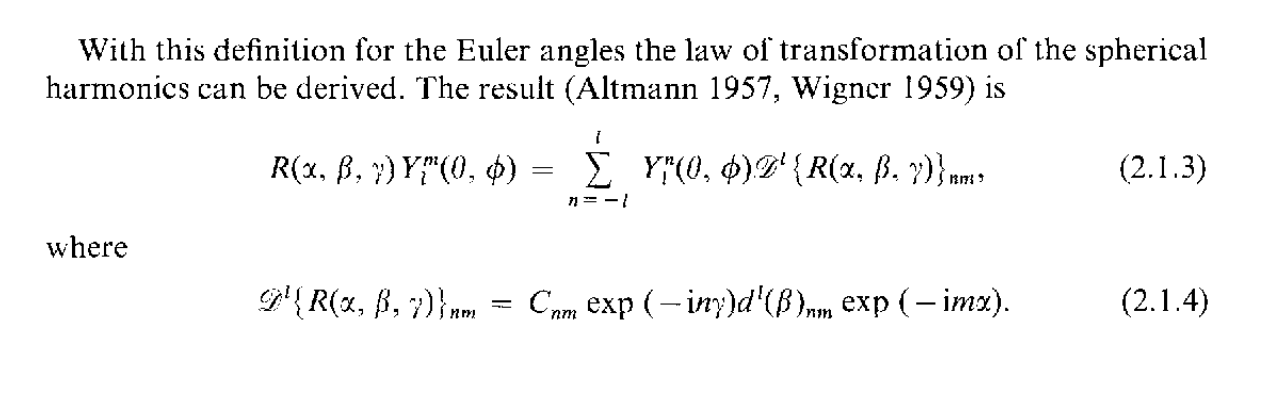
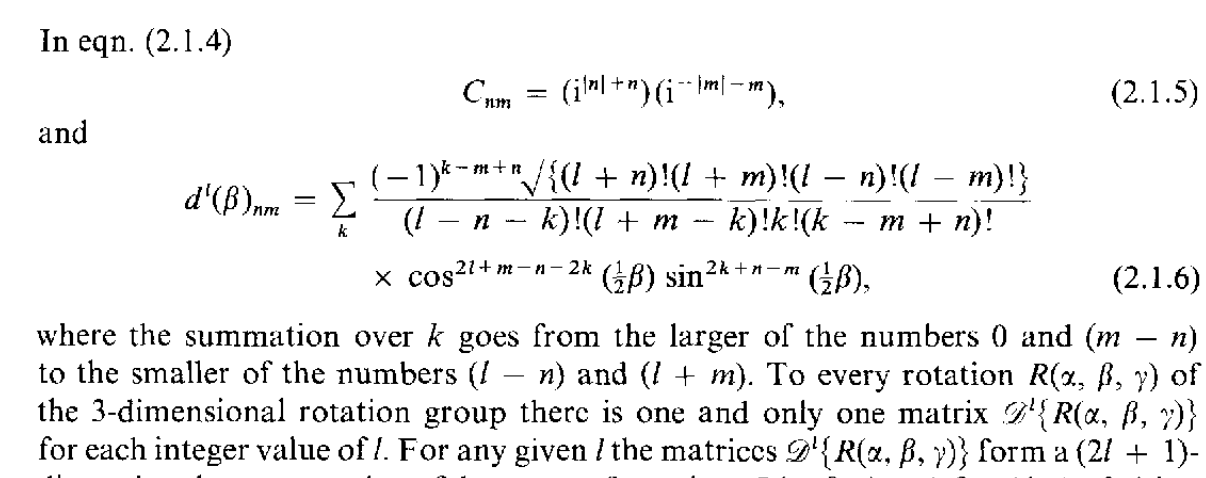
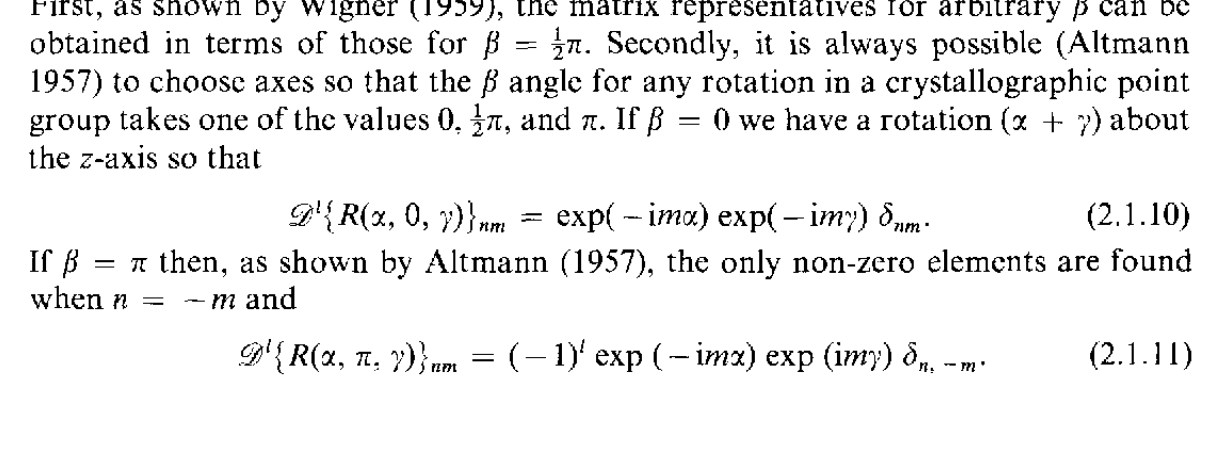

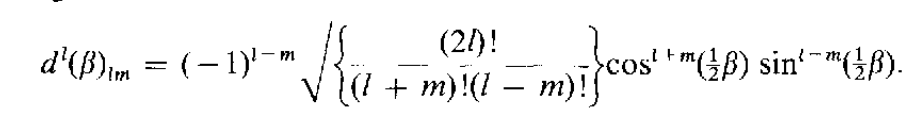

In [250]:
# def Wigner_d(j, m1, m2, beta):
#     k_lim_min = int(np.max([0,m2-m1]))
#     k_lim_max = int(np.min([j+m2,j-m1]))

#     wig_d = sqrt(factorial(j+m1)*factorial(j-m1)*factorial(j+m2)*factorial(j-m2))*Sum((-1)**(m1-m2+k)* \
#             cos(beta/2)**(2*j+m2-m1-2*k)*sin(beta/2)**(m1-m2+2*k)/(factorial(j+m2-k)* \
#             factorial(k)*factorial(m1-m2+k)*factorial(j-m1-k)),(k,k_lim_min,k_lim_max))

#     return wig_d.doit()


In [345]:
from sympy import simplify, re, im, E, I
from sympy import factorial, Sum, symbols, cos, sin, sqrt
from sympy.abc import k

def kronecker(i,j):
    return 0 if i!=j else 1

def Wigner_d(l, n, m, beta):
    k_min = max([0,m-n])
    k_max = min([l-n,l+m])
    Wig_d_prefact = sqrt((factorial(l+n)
                          *factorial(l+m)
                          *factorial(l-n)
                          *factorial(l-m)))
    Wig_d_summands = [((-S(1))**(k - m + n)
                      * cos(beta/2)**(2*l+m-n-2*k)
                      * sin(beta/2)**(2*k+n-m)
                      / factorial(l - n -k) 
                      / factorial(l + m - k)
                      / factorial(k)
                      / factorial(k-m+n)
                      )
                      for k in range(k_min,k_max+1)]
    Wig_d = (Wig_d_prefact*sum(Wig_d_summands)).doit()
    return Wig_d

def Wigner_D(l, n, m, alpha, beta, gamma):
    args = (l, n, m, alpha, beta, gamma) 
    if args in Wigner_D.values.keys():
      return Wigner_D.values[args]
    if beta == 0:
#       Wig_D = exp(-I*m*alpha-I*m*gamma) * kronecker(n,m)
      if n == m:
        Wig_D = (cos(-m*alpha-m*gamma)+I*sin(-m*alpha-m*gamma))
      else:
        Wig_D = 0
    elif beta == pi:
      if n == -m:
        Wig_D = (-1)**l * (cos(-m*alpha + m*gamma)+I*sin(-m*alpha + m*gamma))
      else:
        Wig_D = 0
    else:
      Wig_D_0 = I**(abs(n)+n-abs(m)-m)
      Wig_D_1 = (cos(-n*gamma-m*alpha)+I*sin(-n*gamma-m*alpha)) * Wigner_d(l,n,m,beta)
      Wig_D = Wig_D_0 * Wig_D_1
      Wig_D = Wig_D
    return Wig_D
Wigner_D.values = {}

# Wigner_D.values = pickle.load(open('/Users/juan/Google Drive/Zia Lab/Codebase/zialab/data/wigner_D.pkl','rb'))
  
def Wigner_d_old(j, m1, m2, beta):
    k_lim_min = int(np.max([0,m2-m1]))
    k_lim_max = int(np.min([j+m2,j-m1]))

    wig_d = sqrt(factorial(j+m1)*factorial(j-m1)*factorial(j+m2)*factorial(j-m2))*Sum((-1)**(m1-m2+k)* \
            cos(beta/2)**(2*j+m2-m1-2*k)*sin(beta/2)**(m1-m2+2*k)/(factorial(j+m2-k)* \
            factorial(k)*factorial(m1-m2+k)*factorial(j-m1-k)),(k,k_lim_min,k_lim_max))

    return wig_d.doit()

def Wigner_D_old(j, m1, m2, alpha, beta, gamma):
    args = (j, m1, m2, alpha, beta, gamma) 
    if args in Wigner_D.values.keys():
      return Wigner_D.values[args]
    if beta == 0:
      WigD = exp(-I*m1*alpha-I*m2*gamma) * kronecker(m1,m2)
    elif beta == pi:
      WigD = (-1)**j * exp(-I*m1*alpha) * exp(I*m)
    else:
      WigD = simplify((exp(-I*m1*alpha).rewrite(cos)*Wigner_d(j, m1, m2, beta)*exp(-I*m2*gamma).rewrite(cos)).doit())
    Wigner_D.values[args] = WigD
    return WigD


## Computing all necessary values

In [346]:
wigner_angles = []
for group in CPG.Groups:
  for op in group.ParameterTable:
#     alpha, beta, gamma = op[:3]
    wigner_angles.append(tuple(op[:3]))

In [347]:
print('In total there are %d angles fed into Wigner_D.' % len(wigner_angles))
print('Only %d are unique.' % len(list(set(wigner_angles))))

In total there are 332 angles fed into Wigner_D.
Only 32 are unique.


In [348]:
wigner_angles = list(set(wigner_angles))

For each value of l there are $32 * (2l+1)^2$ values to calculate.

In [349]:
wigner_values = {l:32*(2*l+1)**2 for l in range(5)}
print(wigner_values)

{0: 32, 1: 288, 2: 800, 3: 1568, 4: 2592}


In [350]:
sum(list(wigner_values.values()))

5280

There are 5280 different values to be evaluated.

In [351]:
all_wigner_values = []
for l in range(8):
  all_wigner_values.extend([(l,m,mp,*angls) for (m,mp,angls) in product(range(-l,l+1),range(-l,l+1),wigner_angles)])

In [352]:
len(all_wigner_values)

21760

In [353]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
print('Num cores = %d' % num_cores)

Num cores = 20


In [354]:
all_Wigner_results = Parallel(n_jobs = num_cores)(delayed(Wigner_D)(*args) for args in all_wigner_values)

In [355]:
# all_wigner = dict(zip(all_wigner_values, all_Wigner_results))

In [356]:
# pickle.dump(all_wigner, open('/Users/juan/Google Drive/Zia Lab/Codebase/zialab/data/wigner_D.pkl','wb'))

In [357]:
from sympy import conjugate

In [480]:
group_widget = widgets.Dropdown(options=CPG.AllGroupLabels,
                         value='T_h',
                         description='Group:'
                       )
operation_widget = widgets.Dropdown(options=CPG.Groups[CPG.AllGroupLabels.index('T_h')].Elements,
                         value='E',
                         description='Operation:'
                       )

l_widget = widgets.IntSlider(min=0, max=8, value=3)

def on_update_group_widget(*args):
    operation_widget.options = CPG.Groups[CPG.AllGroupLabels.index(group_widget.value)].Elements  #d[brand_widget.value]

group_widget.observe(on_update_group_widget, 'value')

def aWignerD(i,l,op):
  op_idx = CPG.Groups[CPG.AllGroupLabels.index(i)].Elements.index(op)
  args = CPG.Groups[CPG.AllGroupLabels.index(i)].ParameterTable[op_idx][:3]
  mah = Matrix([[Wigner_D(l,m,mp,*args) for m in range(-l,l+1)] for mp in range(-l,l+1)])
  display(simplify(mah))

out = widgets.interactive_output(aWignerD, {'i': group_widget, 
                                            'l': l_widget,
                                            'op': operation_widget})


widgets.VBox([widgets.VBox([group_widget,operation_widget,l_widget,out])])

# An example with symmetry-adapted linear combinations (tidy)

In [11]:
%load_ext autoreload
%autoreload 2
from qdef import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
VCF = []
sharm = []
for q in range(1,5):
  wfs = SymmetryAdaptedWFs('C_1',q,False,False,True)
  if wfs:
    sharm.append(wfs)
  for qet in wfs:
    l,m = list(qet.dict.keys())[0]
    m = abs(m)
    VCF.append(SubSubSymbol('B',l,m)*qet)

In [14]:
for wf in VCF:
  display(wf.as_ket(True,True))

{B}_{{1}{0}}*|10>

I*{B}_{{1}{1}}*|11> + I*{B}_{{1}{1}}*|1\bar{1}>

{B}_{{1}{1}}*|11> - {B}_{{1}{1}}*|1\bar{1}>

{B}_{{2}{0}}*|20>

I*{B}_{{2}{1}}*|21> + I*{B}_{{2}{1}}*|2\bar{1}>

{B}_{{2}{1}}*|21> - {B}_{{2}{1}}*|2\bar{1}>

{B}_{{2}{2}}*|22> + {B}_{{2}{2}}*|2\bar{2}>

I*{B}_{{2}{2}}*|22> - I*{B}_{{2}{2}}*|2\bar{2}>

{B}_{{3}{0}}*|30>

I*{B}_{{3}{1}}*|31> + I*{B}_{{3}{1}}*|3\bar{1}>

{B}_{{3}{1}}*|31> - {B}_{{3}{1}}*|3\bar{1}>

{B}_{{3}{2}}*|32> + {B}_{{3}{2}}*|3\bar{2}>

I*{B}_{{3}{2}}*|32> - I*{B}_{{3}{2}}*|3\bar{2}>

I*{B}_{{3}{3}}*|33> + I*{B}_{{3}{3}}*|3\bar{3}>

{B}_{{3}{3}}*|33> - {B}_{{3}{3}}*|3\bar{3}>

{B}_{{4}{0}}*|40>

I*{B}_{{4}{1}}*|41> + I*{B}_{{4}{1}}*|4\bar{1}>

{B}_{{4}{1}}*|41> - {B}_{{4}{1}}*|4\bar{1}>

{B}_{{4}{2}}*|42> + {B}_{{4}{2}}*|4\bar{2}>

I*{B}_{{4}{2}}*|42> - I*{B}_{{4}{2}}*|4\bar{2}>

I*{B}_{{4}{3}}*|43> + I*{B}_{{4}{3}}*|4\bar{3}>

{B}_{{4}{3}}*|43> - {B}_{{4}{3}}*|4\bar{3}>

{B}_{{4}{4}}*|44> + {B}_{{4}{4}}*|4\bar{4}>

I*{B}_{{4}{4}}*|44> - I*{B}_{{4}{4}}*|4\bar{4}>

In [15]:
wfs = SymmetryAdaptedWFs('D_2',q,False,False,True)

In [16]:
wfs

[{(4, -4): 1, (4, 4): 1}, {(4, -2): 1, (4, 2): 1}, {(4, 0): 1}]

# An example with symmetry-adapted linear combinations (scratch paper)

Here's an adapted version of the previous SymmetryAdaptedWF that uses qets instead of Ynms. It is necessary to redefine `RYlm` `SymmetryAdaptedWF` and define a couple more things that are necessary to fix the previous implementation.

In [1536]:
from qdef import CPGroups
from IPython.display import Latex
from sympy import GramSchmidt

CPG = CPGroups()

def real_or_imagined(qet):
  '''
  for a given superposition of
  spherical harmonics, determine
  if the total has a pure imaginary (i),
  pure real (r), or mixed character (m),
  it assumes that the coefficients in
  the superposition are all real
  '''
  chunks = dict(qet.dict)
  valences = []
  for key in list(chunks.keys()):
    if key not in chunks.keys():
      continue
    l, m = key
    chunk = chunks[key]
    if (l,-m) in chunks:
      partner = chunks[(l,-m)]
      if abs(partner) == abs(chunk):
        if sign(partner) == sign(chunk):
          if m%2 == 0:
            valences.append("r")
          else:
            valences.append("i")
        else:
          if m%2 == 0:
            valences.append("i")
          else:
            valences.append("r")
      else:
        valences.append("m")
      chunks.pop((l,-m))
    else:
      valences.append("m")
    if m!=0: # if equal to zero this would have been done already
      chunks.pop(key)
  valences = list(set(valences))
  if len(valences) > 1:
    return "m"
  else:
    return valences[0]

def RYlm(l, m, alpha, beta, gamma, detRot):
    '''This would be rotateHarmonic in the Mathematica code. It is used
    in the projection of the spherical harmonics to create symmetry
    adapted wavefunctions.
    '''
    Rf = Qet()
    for nn in range(-l,l+1):
        wigD = Wigner_D(l, m, nn, alpha, beta, gamma)
        if wigD != 0:
          Rf = Rf + Qet({(l,nn): wigD}) 
    return (S(detRot)**l) * Rf

def SymmetryAdaptedWF(group, l, m):
  '''
  This returns the proyection of Y_l^m
  on the trivial irreducible representation
  of the given group
  '''
  if isinstance(group,str):
      group = CPG.Groups[CPG.AllGroupLabels.index(group)]
  degree = 1
  # Order of the group which  is  equal  to 
  # the number of the elements
  order = len(group.Elements)
  SALC = Qet()
  # This sum is over all elements of the group
  for group_idx, group_op in enumerate(group.Elements):
    alpha, beta, gamma, detRot = group.ParameterTable[group_idx][:4]
    SALC += RYlm(l,m,alpha,beta,gamma,detRot)
  SALC = (S(1)/order)*SALC
  SALC = SALC.apply(lambda x,y : (x, simplify(y)))
  return SALC

def linearly_independent(vecs):
  '''given a list of vectors
  return the largest subset which
  of linearly independent ones
  and the indices that correspond
  to them in the original list
  '''
  matrix = Matrix(vecs).T
  good_ones = matrix.rref()[-1]
  return good_ones, [vecs[idx] for idx in good_ones]

def SymmetryAdaptedWFs(group, l, normalize=True, verbose=False, sympathize=True):
  '''For a given group and a given value of
  l, this returns a set of linearly independent
  symmetry adapted functions which are also real-valued.
  If the set that is found initially contains combinations that are
  not purely imaginary or pure real, then the assumption
  is made that this set contains single spherical
  harmonics, and then sums and differences between
  m and -m are given by doing this through the values
  of |m| for the functions with mixed character.'''
  
  # apply the projection operator on the trivial irreducible rep
  # and collect the resulting basis functions
  # together with the values of (l,m) included
  flags = []
  WFs = []
  complete_basis = []
  for m in range(-l,l+1):
    aWF = SymmetryAdaptedWF(group, l, m)
    if len(aWF.dict)>0:
      WFs.append(aWF)
      complete_basis.extend(aWF.basis())
    
  complete_basis = list(sorted(list(set(complete_basis))))
  # to see if they are linearly independent
  # convert the WFs to vectors on the basis collected
  # above
  vecs = [WF.vec_in_basis(complete_basis) for WF in WFs]
  lin_indep_idx, lin_indep_vecs = linearly_independent(vecs)

  # reduce the WFs to a linearly independent set
  
  WFs = [WFs[i] for i in lin_indep_idx]
  # test to see if the included WFs are real, imaginary, or mixed
  # if real, keep as is
  # if purely imaginary, multiply by I
  # if mixed then collect for further processing
  realWFs = []
  mixedWFs = []
  for WF in WFs:
    valence = real_or_imagined(WF)
    if normalize:
      norm = WF.norm()
      WF = WF*(S(1)/norm)
    if valence == 'r':
      realWFs.append(WF)
    elif valence == 'i':
      realWFs.append(I*WF)
    elif valence == 'm':
      flags.append('m')
      mixedWFs.append(WF)
  # collect the values of |m| included in the mixed combos
  mixedMs = set()
  if (len(mixedWFs) != 0) and verbose:
    print("\nMixtures found, unmixing...")
  for WF in mixedWFs:
    # ASSUMPTION: both m and -m are in there and only as singles
    assert len(WF.dict) == 1
    for key, val in WF.dict.items():
      mixedMs.add(abs(key[1]))
  # for the values of m in mixedMs compute the real sums
  # and differences
  for m in mixedMs:
    if m%2 == 0:
      qp = Qet({(l,m): 1}) + Qet({(l,-m): 1})
      qm = Qet({(l,m): I}) + Qet({(l,-m): -I})
      if normalize:
        qp = qp*(S(1)/sqrt(2))
        qm = qm*(S(1)/sqrt(2))
      realWFs.append(qp)
      realWFs.append(qm)
    elif m%2 == 1:
      qp = Qet({(l,m): I}) + Qet({(l,-m): I})
      qm = Qet({(l,m): 1}) + Qet({(l,-m): -1})
      if normalize:
        qp = qp*(S(1)/sqrt(2))
        qm = qm*(S(1)/sqrt(2))
      realWFs.append(qp)
      realWFs.append(qm)
  # the resulting list of realWFs must be of equal lenght
  # than WFs which in turn is equal to the number of linearly
  # independent projectd basis functions
  if len(realWFs) != len(WFs):
    raise Exception("FAILED: there are less real combos than originally")
  # in addition
  # must check that the resulting basis is still linearly independent
  # must run through the same business of collecting all the represented
  # spherical harmonics, converting that to coefficient vectors
  # and testing for linear independence
  complete_basis = []
  for WF in realWFs:
    complete_basis.extend(WF.basis())
  complete_basis = list(sorted(list(set(complete_basis))))

  vecs = [WF.vec_in_basis(complete_basis) for WF in realWFs]
  lin_indep_idx, lin_indep_vecs = linearly_independent(vecs)
  if len(lin_indep_idx) != len(WFs):
    raise Excepction("FAILED: +- mixture was not faithful")
  # make the linearly independent vectors orthonormal
#   lin_indep_vecs = GramSchmidt([Matrix(vec) for vec in lin_indep_vecs])
  lin_indep_vecs = list(map(list,GramSchmidt([Matrix(vec) for vec in lin_indep_vecs], normalize)))
  finalWFs = []
  if sympathize:
    better_vecs = []
    for vec in lin_indep_vecs:
      clear_elements = [abs(v) for v in vec if v!=0]
      if len(list(set(clear_elements))) == 1:
        better_vec = [0 if vl == 0 else sign(vl) for vl in vec]
        better_vecs.append(better_vec)
      else:
        better_vecs.append(vec)
    lin_indep_vecs = better_vecs
  for vec in lin_indep_vecs:
    qdict = {k:v for k,v in zip(complete_basis, vec)}
    finalWFs.append(Qet(qdict))
  return finalWFs

Kurvits used a restriction on the Bkq from the Morrison book in which the expansion is not made in terms of symmetry adapted basis functions but on spherical harmonics.

Morrison then goes on to show by hand how it is that the symmetry operations of the groups limit the possible values of the coefficients.

In our case, our expansion is in terms of symmetry adapted basis functions, in which case the restriction given in Morrison does not apply to our expression for the crystal field. Jon danced around this restriction by playing with the coefficients. Evidence of this is him fudging the coefficients for the cubic groups, and the fact that C1 is evidently missing terms that should be on there: for example, for l=1, there should also be a difference of C1-1 and C11.

As I now understand the problem should be stated as follows:

Given a group $G$, find the most general expression for a real-valued scalar potential that satisfies the symmetry of the group. These construction blocks are what Bradley terms real surface harmonics.

For this the projection operator on the trivial irreducible representation can be used as a starting point. But there are a number of addional things that have to be taken into account.

The projection operator will not necessarilly give a linearly independent set of basis functions, and the combinations of spherical harmonics are not necessarily either purely real or purely imaginary.

Therefore, for a given value of l, one must first find the projection of all the Yl,m's, and find a subset with the largest amount possible of linearly independent combinations of spherical harmonics, this can be done by finding the pivots in a reduced-row echelon form.

After this one may then go to analyze the "reality" of each combination. If the combination is real, keep as it is, if the combination is purely imaginary, then multiply by I, if the combination is mixed, save for later processing.

For the combinations that are mixed, the problem would be then to find a linear transformation of that subset, that would yield basis functions that are real. Fortunately this is not necessary. Whenever there is a mixed projected spherical harmonic, it is alone and not mixed with other values of m; also, whenever a value of m appears, another projected basis function will have -m. Given this, it is possible to produce a new set of purely real combinations by taking differences and sums.

There is an additional problem. The linearly independent subset is not necessarily orthonormal. In which case one additional thing that needs to be done is to apply the Gram-Schmidt orthonormalization to the this subset.

Having found this set of real-valued symmetry adapted combinations of spherical harmonics, the crystal field is then composed by weighting each of those with a real coefficient.

The most elegant way of summarizing all these is given in Bradley's book on group theory. For all groups but the cubic ones, the nonzero terms follow clear patterns that may be stated once and for all for all values of l,m. For the cubic ones a more involved calculation is necessary, and numerical tables are given for these. Note that in Bradley they also use sums and differences which they term `c` or `s`, and expansions are often given with this combinations taken into account.


In [1537]:
comparison_group = 'T'
l = 12
wfs = SymmetryAdaptedWFs(comparison_group,l,True,False)

In [1538]:
# here i'm comparing with the (0) coefficients of
# table 2.6 in Bradley

bradley = {4:0.764,
           6:0.354,
           8:0.718,
           10:0.411,
           12:0.695}
for k in bradley:
  waifus = SymmetryAdaptedWFs(comparison_group,k,True,False,True)
  for waifu in waifus:
    if (k,0) in waifu.dict.keys():
      found = waifu.dict[(k,0)]
      break
  print(N(found,3),bradley[k])

# save for the sign, the results match exactly
# for the first four, and there's a mismatch
# in the final one, for l=12 there are three
# surface harmonics according to bradley
# in our case we also have three
# note that there is not a single solution
# to this problem there's many linear
# combinations that would give the same
# symmetry adapted basis

0.764 0.764
-0.354 0.354
0.718 0.718
-0.411 0.411
0.655 0.695


In [1539]:
wfs = SymmetryAdaptedWFs('D_2',q,False,False,True)

In [1540]:
better_vecs = []
for vec in lin_indep_vecs:
  print(vec)
  if len(list(set(list(map(abs,vec))))) == 1:
    better_vec = [0 if vl == 0 else sign(vl) for vl in vec]
    better_vecs.append(better_vec)
  else:
    better_vecs.append(vec)

[1, 0, 0, 0, 1]
[0, 1, 0, 1, 0]
[0, 0, 1, 0, 0]


In [1541]:
VCF = []
sharm = []
for q in range(1,5):
  wfs = SymmetryAdaptedWFs('C_1',q,False,False,True)
  if wfs:
    sharm.append(wfs)
  for qet in wfs:
    l,m = list(qet.dict.keys())[0]
    m = abs(m)
    VCF.append(SubSubSymbol('B',l,m)*qet)

In [1542]:
for wf in VCF:
  display(wf.as_ket(True,True))

{B}_{{1}{0}}*|10>

I*{B}_{{1}{1}}*|11> + I*{B}_{{1}{1}}*|1\bar{1}>

{B}_{{1}{1}}*|11> - {B}_{{1}{1}}*|1\bar{1}>

{B}_{{2}{0}}*|20>

I*{B}_{{2}{1}}*|21> + I*{B}_{{2}{1}}*|2\bar{1}>

{B}_{{2}{1}}*|21> - {B}_{{2}{1}}*|2\bar{1}>

{B}_{{2}{2}}*|22> + {B}_{{2}{2}}*|2\bar{2}>

I*{B}_{{2}{2}}*|22> - I*{B}_{{2}{2}}*|2\bar{2}>

{B}_{{3}{0}}*|30>

I*{B}_{{3}{1}}*|31> + I*{B}_{{3}{1}}*|3\bar{1}>

{B}_{{3}{1}}*|31> - {B}_{{3}{1}}*|3\bar{1}>

{B}_{{3}{2}}*|32> + {B}_{{3}{2}}*|3\bar{2}>

I*{B}_{{3}{2}}*|32> - I*{B}_{{3}{2}}*|3\bar{2}>

I*{B}_{{3}{3}}*|33> + I*{B}_{{3}{3}}*|3\bar{3}>

{B}_{{3}{3}}*|33> - {B}_{{3}{3}}*|3\bar{3}>

{B}_{{4}{0}}*|40>

I*{B}_{{4}{1}}*|41> + I*{B}_{{4}{1}}*|4\bar{1}>

{B}_{{4}{1}}*|41> - {B}_{{4}{1}}*|4\bar{1}>

{B}_{{4}{2}}*|42> + {B}_{{4}{2}}*|4\bar{2}>

I*{B}_{{4}{2}}*|42> - I*{B}_{{4}{2}}*|4\bar{2}>

I*{B}_{{4}{3}}*|43> + I*{B}_{{4}{3}}*|4\bar{3}>

{B}_{{4}{3}}*|43> - {B}_{{4}{3}}*|4\bar{3}>

{B}_{{4}{4}}*|44> + {B}_{{4}{4}}*|4\bar{4}>

I*{B}_{{4}{4}}*|44> - I*{B}_{{4}{4}}*|4\bar{4}>

In [1555]:
all_spharms = {}
lmax = 33
for group in CPG.AllGroupLabels:
  print(group)
  spharms = {}
  for q in range(1,lmax+1):
    print(q,end='|')
    wfs = SymmetryAdaptedWFs(group,q,True,False,False)
    spharms[q] = wfs
  all_spharms[group] = spharms

C_1
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_i
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_2
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_s
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_2h
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|D_2
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_2v
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|D_2h
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_4
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|S_4
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_4h
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|2

In [1556]:
!pushover "finished"

In [1557]:
import pickle

In [1783]:
def simplifier(dee):
  ndee = dict()
  for k,v in dee.items():
    ndee[k] = simplify(v)
  return ndee
all_spharms_normal = {}
lmax = 33
for group in CPG.AllGroupLabels:
  print(group)
  spharms = {}
  for q in range(1,lmax+1):
    print(q,end='|')
    wfs = [simplifier(qet.dict) for qet in all_spharms[group][q]]
    spharms[q] = wfs
  all_spharms_normal[group] = spharms

C_1
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_i
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_2
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_s
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_2h
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|D_2
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_2v
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|D_2h
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_4
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|S_4
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|C_4h
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|2

In [1784]:
!pushover "done"

In [1785]:
fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/surface_harmonics.pkl'
pickle.dump(all_spharms_normal, open(fname,'wb'))

In [2025]:
from sympy import exp

In [2032]:
from sympy import S

In [2031]:
from sympy import Dummy, sympify, Function

In [1755]:
rainbow = {}
table = []
for group in CPG.AllGroupLabels:
  bow = []
  for q in range(1,34):
    #bow[q] = [len(qet) for qet in all_spharms_normal[group][q]]
    bow.append(len(all_spharms_normal[group][q]))
  rainbow[group] = bow
  table.append(bow)
totals = np.cumsum(np.array(table),axis=1)[:,-1]
# table = np.array(table).T
labels = np.array(CPG.AllGroupLabels)
sorter = np.argsort(totals)
table = (np.array(table)[sorter]).T
labels = labels[sorter]
glables = []
for label in labels:
  if '_' in label:
    glables.append('{%s}_{%s}' % tuple(label.split('_')))
  else:
    glables.append(label)
totals = totals[sorter]

In [1973]:
all_spharms_normal['D_3h'][6]

[{(6, -6): sqrt(2)/2, (6, 6): sqrt(2)/2}, {(6, 0): 1}]

In [1756]:
import pyperclip

In [1766]:
display(Math(' ,\, '.join(list(map(str,totals)))))

<IPython.core.display.Math object>

In [1782]:
simplify((-254943061571*sqrt(13878236240924368383066)/19573839465131338690974870 + 38576171*sqrt(302679702426)/106228013495430)/sqrt(2*(-104923009*sqrt(2455805986590)/1699648215926880 + 104923009*sqrt(112601721789074669924190)/363943972828206887520)**2 + (-37162595485*sqrt(240159431474561048084778)/226943066262392332648984 + 113717*sqrt(5237797079658)/1231629141976)**2 + 2*(-40892049810821*sqrt(6437840237663058398543)/52196905240350236509266320 + 157548221*sqrt(140407147823)/283274702654480)**2 + 2*(-254943061571*sqrt(13878236240924368383066)/19573839465131338690974870 + 38576171*sqrt(302679702426)/106228013495430)**2 + 2*(30478259679123*sqrt(116740457791304981104614)/104393810480700473018532640 + 79000677*sqrt(2546070438054)/566549405308960)**2 + 2*(-3272897729560943*sqrt(580630752276979683)/78295357860525354763899480 + 3006875041*sqrt(12663363)/18474437129640)**2))

7*sqrt(10056908927)/3442084

In [1757]:

header = r'\begin{array}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|} \hline'
header = header + '\n & ' + ' & '.join(list(map(lambda x: ' %s ' % x, glables))) + ' \\\\ \\hline \n'
midway = (' \\\\ \n '.join([' & '.join([str(idx+1)]+list(map(str,(tab)))) for idx, tab in enumerate(table)]))
footer = '\\\\ \\hline \n'+'\end{array}'
ltable = ('\n'.join([header,midway,footer]))

In [2009]:
pyperclip.copy(str(all_spharms_normal))

In [1758]:
pyperclip.copy(ltable)

In [1759]:
display(Math(ltable))

<IPython.core.display.Math object>

In [1640]:
from itertools import accumulate

In [ ]:
table = []
for group in 

In [1773]:
comparer = np.array(list(accumulate(rainbow['C_6v'])))

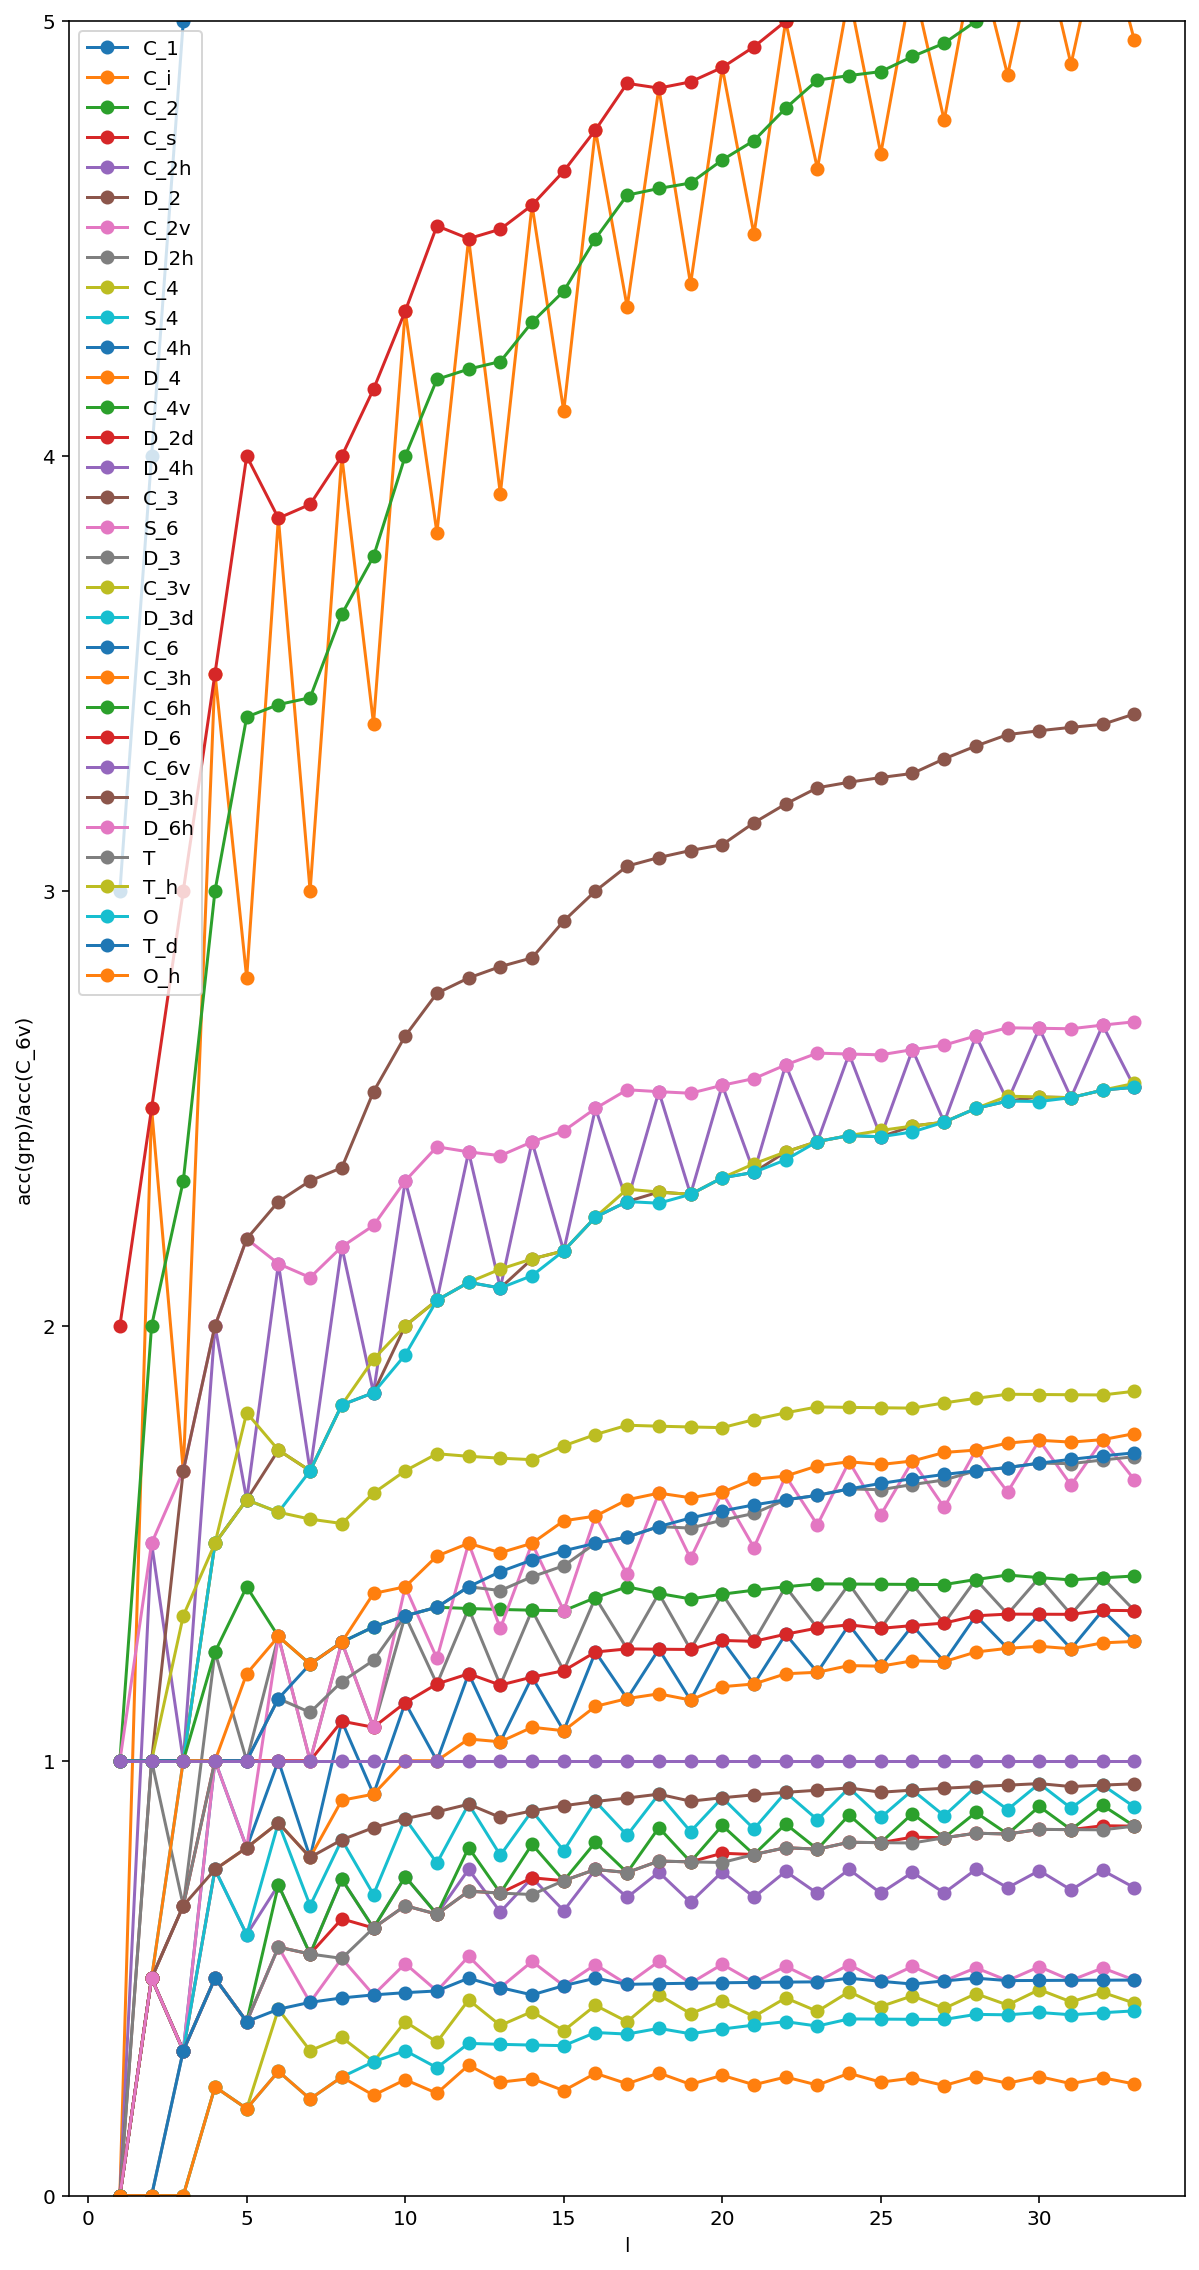

In [2010]:
plt.figure(figsize=(10,20))
for group in CPG.AllGroupLabels:
  plt.plot(range(1,34),np.array(list(accumulate(rainbow[group])))/comparer,'o-',label=group)
plt.legend()
plt.ylabel('acc(grp)/acc(C_6v)')
plt.xlabel('l')
plt.ylim(0,5)
plt.show()

In [1997]:
# D3h comparison
lmax = 33
lms = []
ls = range(0,lmax+1,2)
for l in ls:
  ms = range(0,l+1,6)
  lms.extend([(l,m) for m in ms])
ls = range(3,lmax+1,2)
for l in ls:
  ms = range(3,l+1,6)
  lms.extend([(l,m) for m in ms])
lms = np.array(lms)

In [2002]:
magic_nums = [list(lms[:,0]).count(l) for l in range(34)]

In [2007]:
print('\n'.join(list(map(str,(magic_nums)))))

1
0
1
1
1
1
2
1
2
2
2
2
3
2
3
3
3
3
4
3
4
4
4
4
5
4
5
5
5
5
6
5
6
6


In [1953]:
# the bradley slash
def bradley_parser(bp):
  rows = bp.split('\n')
  row0 = rows[0]
  group, l_bounds, m_bound = row0.split(' ')
  l_period = (l_bounds.split(',')[-1])
  if l_period != '*':
    l_period = int(l_period)
  m_period = (m_bound.split(',')[-1])
  if m_period != '*':
    m_period = int(m_period.replace('+',''))
  m_dir = '*'
  if '+' in m_bound:
    m_dir = '+'
  ls_and_ms = []
  for row in rows[1:]:
    raw_chunks = row.split(' ')
    chunks = []
    for chunk in raw_chunks:
      try:
        chunks.append(int(chunk))
      except:
        chunks.append(chunk)
    ls_and_ms.append(chunks)
  bparse = {'group': group,
           'l_period': l_period,
           'm_period': m_period,
           'm_dir': m_dir,
           'lms': ls_and_ms}
  return bparse
cyclic=['''C_i l,2 m,*
0 * cs''',
'''C_3h l,2 m,6
0 0 cs
3 3 cs''',
'''C_1h l,2 m,2
0 0 cs
1 1 cs''',
'''C_4 l,* m,4
* 0 cs''',
'''C_3 l,* m,3
* 0 cs''',
'''S_4 l,2 m,4
0 0 cs
3 2 cs''',
'''C_6 l,* m,6
* 0 cs''']
dihedrals=['''D_2 l,2 m,+2
0 0 c
3 2 s''',
'''C_2v l,* m,+2
* 0 c''',
'''D_3 l,2 m,+6
0 0 c
4 3 s
3 3 c
7 6 s''',
'''D_2d l,2 m,+4
0 0 c
3 2 s''',
'''C_3v l,* m,+3
* 0 c''',
'''D_6 l,2 m,+6
0 0 c
7 6 s''',
'''D_4 l,2 m,+4
0 0 c
5 4 s''',
'''C_4v l,* m,+4
* 0 c''',
'''C_6v l,* m,+6
* 0 c''',
'''D_3h l,2 m,+6
0 0 c
3 3 c''']
datatabs = cyclic + dihedrals

In [1965]:
def surf(surfstring, l_max):
  parsed = bradley_parser(surfstring)
  lms = []
  l_period = 2
#   print(parsed['group'])
  if parsed['l_period'] == '*':
    l_period = 1
  m_period = parsed['m_period']
  if m_period == '*':
    m_period = 1
#   print(parsed['lms'])
  for row in parsed['lms']:
    kind = row[-1]
    if row[0] == '*':
      ls = list(range(0,l_max+1,l_period))
    else:
      ls = list(range(row[0],l_max+1,l_period))
    if row[1] == '*':
      row[1] = 0
    if row[0] == '*':
      row[0] = 0
    for l in ls:
      msplus = list(range(row[1],l+1,m_period))
      if parsed['m_dir'] == '*':
        msminus = list(range(row[1],-l-1,-m_period))
      else:
        msminus = []
      ms = list(sorted(list(set(msplus+msminus))))
      msandls = list(set(list(product([l],ms))))
      if len(msandls)>0:
        lms.extend(msandls)
  return lms

## Spaguetti Code

In [360]:
theta = Symbol("theta", real=True)
phi = Symbol("phi", real=True)

In [635]:
def RYlm(l, m, alpha, beta, gamma, detRot):
    '''This would be rotateHarmonic in the Mathematica code. It is used
    in the projection of the spherical harmonics to create symmetry
    adapted wavefunctions.
    '''
    Rf = Qet()
    for nn in range(-l,l+1):
        wigD = Wigner_D(l, m, nn, alpha, beta, gamma)
        if wigD != 0:
          Rf = Rf + Qet({(l,nn): wigD}) 
    return (S(detRot)**l) * Rf

In [636]:
CPG.Groups[16].Elements

['E', 'C_3', 'C_3`', 'inv', 'S_6`', 'S_6']

In [637]:
# for group in CPG.Groups:
#   print(group.CharacterTable[:])

In [1451]:
def SymmetryAdaptedWF(group, l, m):
  '''
  This returns the proyection of Y_l^m
  on the trivial irreducible representation
  of the given group
  '''
  if isinstance(group,str):
      group = CPG.Groups[CPG.AllGroupLabels.index(group)]
  degree = 1
  # Order of the group which  is  equal  to 
  # the number of the elements
  order = len(group.Elements)
  SALC = Qet()
  # This sum is over all elements of the group
  for group_idx, group_op in enumerate(group.Elements):
    alpha, beta, gamma, detRot = group.ParameterTable[group_idx][:4]
    SALC += RYlm(l,m,alpha,beta,gamma,detRot)
  SALC = (S(1)/order)*SALC
  SALC = SALC.apply(lambda x,y : (x, simplify(y)))
  return SALC

def linearly_independent(vecs):
  '''given a list of vectors
  return the largest subset which
  of linearly independent ones
  and the indices that correspond
  to them in the original list
  '''
  matrix = Matrix(vecs).T
  good_ones = matrix.rref()[-1]
  return good_ones, [vecs[idx] for idx in good_ones]

def SymmetryAdaptedWFs(group, l, normalize=True, verbose=False):
  '''For a given group and a given value of
  l, this returns a set of linearly independent
  symmetry adapted functions which are also real-valued.
  If the set that is found initially contains combinations that are
  not purely imaginary or pure real, then the assumption
  is made that this set contains single spherical
  harmonics, and then sums and differences between
  m and -m are given by doing this through the values
  of |m| for the functions with mixed character.'''
  
  # apply the projection operator on the trivial irreducible rep
  # and collect the resulting basis functions
  # together with the values of (l,m) included
  WFs = []
  complete_basis = []
  for m in range(-l,l+1):
    aWF = SymmetryAdaptedWF(group, l, m)
    if len(aWF.dict)>0:
      WFs.append(aWF)
      complete_basis.extend(aWF.basis())
    
  complete_basis = list(sorted(list(set(complete_basis))))
  # to see if they are linearly independent
  # convert the WFs to vectors on the basis collected
  # above
  vecs = [WF.vec_in_basis(complete_basis) for WF in WFs]
  lin_indep_idx, lin_indep_vecs = linearly_independent(vecs)

  # reduce the WFs to a linearly independent set
  
  WFs = [WFs[i] for i in lin_indep_idx]
  # test to see if the included WFs are real, imaginary, or mixed
  # if real, keep as is
  # if purely imaginary, multiply by I
  # if mixed then collect for further processing
  realWFs = []
  mixedWFs = []
  for WF in WFs:
    valence = real_or_imagined(WF)
    if normalize:
      norm = WF.norm()
      WF = WF*(S(1)/norm)
    if valence == 'r':
      realWFs.append(WF)
    elif valence == 'i':
      realWFs.append(I*WF)
    elif valence == 'm':
      print("mixed")
      mixedWFs.append(WF)
  # collect the values of |m| included in the mixed combos
  mixedMs = set()
  if (len(mixedWFs) != 0) and verbose:
    print("\nMixtures found, unmixing...")
  for WF in mixedWFs:
    # ASSUMPTION: both m and -m are in there and only as singles
    assert len(WF.dict) == 1
    for key, val in WF.dict.items():
      mixedMs.add(abs(key[1]))
  # for the values of m in mixedMs compute the real sums
  # and differences
  for m in mixedMs:
    if m%2 == 0:
      qp = Qet({(l,m): 1}) + Qet({(l,-m): 1})
      qm = Qet({(l,m): I}) + Qet({(l,-m): -I})
      if normalize:
        qp = qp*(S(1)/sqrt(2))
        qm = qm*(S(1)/sqrt(2))
      realWFs.append(qp)
      realWFs.append(qm)
    elif m%2 == 1:
      qp = Qet({(l,m): I}) + Qet({(l,-m): I})
      qm = Qet({(l,m): 1}) + Qet({(l,-m): -1})
      if normalize:
        qp = qp*(S(1)/sqrt(2))
        qm = qm*(S(1)/sqrt(2))
      realWFs.append(qp)
      realWFs.append(qm)
  # the resulting list of realWFs must be of equal lenght
  # than WFs which in turn is equal to the number of linearly
  # independent projectd basis functions
  if len(realWFs) != len(WFs):
    raise Exception("FAILED: there are less real combos than originally")
  # in addition
  # must check that the resulting basis is still linearly independent
  # must run through the same business of collecting all the represented
  # spherical harmonics, converting that to coefficient vectors
  # and testing for linear independence
  complete_basis = []
  for WF in realWFs:
    complete_basis.extend(WF.basis())
  complete_basis = list(sorted(list(set(complete_basis))))

  vecs = [WF.vec_in_basis(complete_basis) for WF in realWFs]
  lin_indep_idx, lin_indep_vecs = linearly_independent(vecs)
  if len(lin_indep_idx) != len(WFs):
    raise Excepction("FAILED: +- mixture was not faithful")
  # make the linearly independent vectors orthonormal
#   lin_indep_vecs = GramSchmidt([Matrix(vec) for vec in lin_indep_vecs])
  lin_indep_vecs = list(map(list,GramSchmidt([Matrix(vec) for vec in lin_indep_vecs], normalize)))
  finalWFs = []
  for vec in lin_indep_vecs:
    qdict = {k:v for k,v in zip(complete_basis, vec)}
    finalWFs.append(Qet(qdict))
  return finalWFs

In [1408]:
SymmetryAdaptedWFs('T',k,True,False)

([{(10, -10): [sqrt(170)/32, 0, -sqrt(114)/96, 0, -sqrt(741)/48, 0, -sqrt(741)/48, 0, -sqrt(114)/96, 0, sqrt(170)/32], (10, -8): [0, sqrt(561)/48, 0, sqrt(11)/8, 0, -sqrt(390)/48, 0, sqrt(11)/8, 0, sqrt(561)/48, 0]},
  {(10, -10): [sqrt(170)/32, 0, -sqrt(114)/96, 0, -sqrt(741)/48, 0, -sqrt(741)/48, 0, -sqrt(114)/96, 0, sqrt(170)/32], (10, -8): [0, sqrt(561)/48, 0, sqrt(11)/8, 0, -sqrt(390)/48, 0, sqrt(11)/8, 0, sqrt(561)/48, 0]}],
 [[sqrt(170)/32,
   0,
   -sqrt(114)/96,
   0,
   -sqrt(741)/48,
   0,
   -sqrt(741)/48,
   0,
   -sqrt(114)/96,
   0,
   sqrt(170)/32],
  [0,
   sqrt(561)/48,
   0,
   sqrt(11)/8,
   0,
   -sqrt(390)/48,
   0,
   sqrt(11)/8,
   0,
   sqrt(561)/48,
   0]])

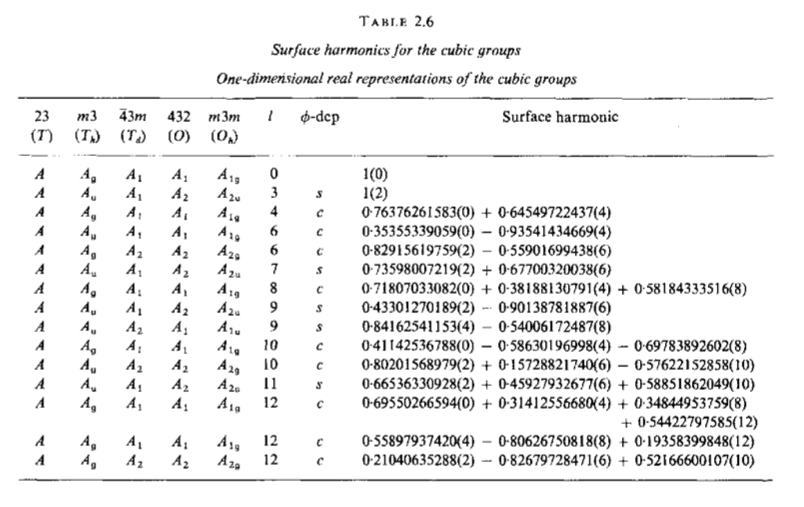

In [1447]:
comparison_group = 'T'

In [1448]:
wfs = SymmetryAdaptedWFs(comparison_group,12,True,False)

In [1450]:
from sympy import GramSchmidt

In [1435]:
wfs, vecs = SymmetryAdaptedWFs(comparison_group,12,True,False)

In [1437]:
wfs, vecs = SymmetryAdaptedWFs(comparison_group,12,True,False)
# for wf in wfs:
#   display(N(wf.as_ket(True, False),6))
complete_basis = []
for wf in wfs:
  complete_basis.extend(wf.basis())
complete_basis = list(sorted(list(set(complete_basis))))
vecs = Matrix([wf.vec_in_basis(complete_basis) for wf in wfs])

In [1444]:
# my resulting basis is now orthonormal
N(vecs*vecs.T,4,chop=True)

Matrix([
[1.0,   0,   0],
[  0, 1.0,   0],
[  0,   0, 1.0]])

In [1445]:
brad12s = [
  '0.69550266594 0 0.31412556680 4 0.34844953759 8 0.54422797585 12',
  '0.55897937420 4 -0.80626750818 8 0.19358399848 12',
  '0.21040635288 2 -0.82679728471 6 0.52166600107 10'
]
tee12 = []
for brad12 in brad12s:
  vec = {i:0 for i in range(-12,13,2)}
  indices = list(map(int,brad12.split(' ')[1::2]))
  coeffs = list(map(float,brad12.split(' ')[0::2]))
  for index, coeff in zip(indices, coeffs):
    if index == 0:
      vec[0] = coeff
    else:
      vec[index] = coeff/sqrt(2.)
      vec[-index] = coeff/sqrt(2.)
  vec = [vec[i] for i in range(-12,13,2)]
  tee12.append(vec)
tee12 = Matrix(tee12)

In [1313]:
N(tee12*tee12.T,4,chop=True)

Matrix([
[1.0,   0,   0],
[  0, 1.0,   0],
[  0,   0, 1.0]])

In [1454]:
# here i'm comparing with the (0) coefficients of
# table 2.6 in Bradley
bradley = {4:0.764,
           6:0.354,
           8:0.718,
           10:0.411,
           12:0.695}
for k in bradley:
  waifus = SymmetryAdaptedWFs(comparison_group,k,True,False)
  for waifu in waifus:
    if (k,0) in waifu.dict.keys():
      found = waifu.dict[(k,0)]
      break
  print(N(found,3),bradley[k])
# save for the sign, the results match exactly
# for the first four, and there's a mismatch
# in the final one, for l=12 there are three
# surface harmonics according to bradley
# in our case we also have three
# note that there is not a single solution
# to this problem there's many linear
# combinations that would give the same
# symmetry adapted basis

0.764 0.764
-0.354 0.354
0.718 0.718
-0.411 0.411
0.655 0.695


In [1455]:
VCF = []
for q in range(1,5):
  for qet in SymmetryAdaptedWFs('T',q,False,False):
    l,m = list(qet.dict.keys())[0]
    m = abs(m)
    VCF.append(SubSubSymbol('B',l,m)*qet)

Kurvits used a restriction on the Bkq from the Morrison book in which the expansion is not made in terms of symmetry adapted basis functions but on spherical harmonics.

Morrison then goes on to show by hand how it is that the symmetry operations of the groups limit the possible values of the coefficients.

In our case, our expansion is in terms of symmetry adapted basis functions, in which case the restriction given in Morrison does not apply to our expression for the crystal field.

As I see it the problem should be stated as follows:

Given a group G, to find the most general expression for a real-valued scalar potential that satisfies the symmetry of the group. For this the projection operator on the trivial irreducible representation can be used as a starting point.

There's a few things that need to be taken into account. The projection operator will not necessarilly give a linearly independent set of basis functions, and the combinations of spherical harmonics are not necessarily either purely real or purely imaginary.

Therefore, for a given value of l, one must first find the projection of all the Yl,m's, and find a subset with the largest amount possible of linearly independent combinations of spherical harmonics.

After this one may then go to analyze the "reality" of each combination. If the combination is real, keep as it is, if the combination is purely imaginary, then multiply by I, if the combination is mixed, save for later processing.

For the combinations that are mixed, the problem would be then to find a linear transformation of that subset, that would yield basis functions that are real. Fortunately this is not necessary. Whenever there is a mixed projected spherical harmonic, it is alone and not mixed with other values of m; also, whenever a value of m appears, another projected basis function will have -m. Given this it is possible to produce a new set of purely real combinations by taking differences and sums.

There is an additional problem. The linearly independent subset is not necessarily orthonormal. In which case one additional thing that needs to be done is to apply the Gram-Schmidt orthonormalization to the this subset.

Having found this set of real-valued symmetry adapted combinations of spherical harmonics. The crystal field is then composed by weighting each of those with a real coefficient.

The most elegant way of summarizing all these is given in Bradley's book on group theory. For all groups but the cubic ones, the nonzero terms follow clear patterns that may be stated once and for all for all values of l,m. For the cubic ones a more involved calculation is necessary, and numerical tables are given for these. Note that in Bradley they also use sums and differences which they term `c` or `s`, and expansions are often given with this combinations taken into account.


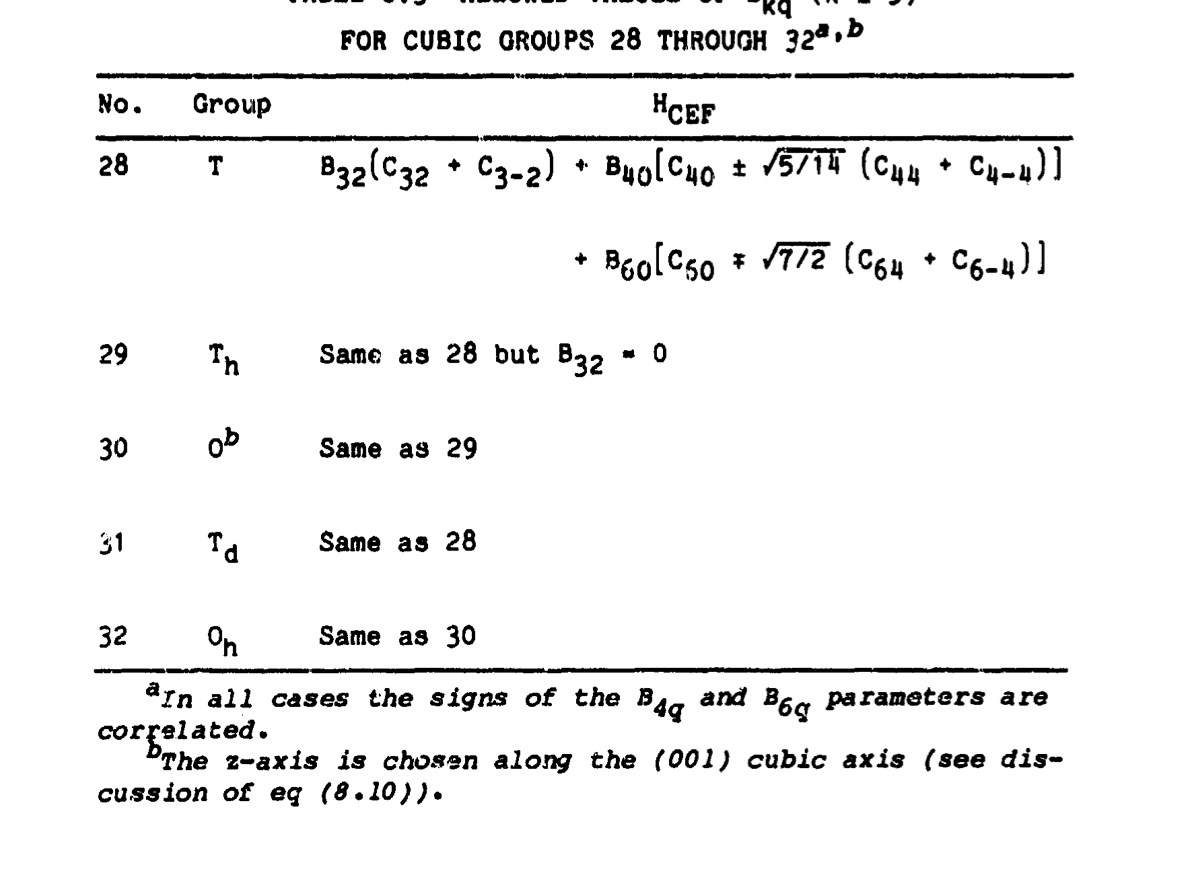

In [1459]:
wfs = SymmetryAdaptedWFs('T',12,True,False)
# for wf in wfs:
#   display(N(wf.as_ket(True, False),6))
complete_basis = []
for wf in wfs:
  complete_basis.extend(wf.basis())
complete_basis = list(sorted(list(set(complete_basis))))
vecs = Matrix([wf.vec_in_basis(complete_basis) for wf in wfs])

In [1460]:
# my vectors are *not* orthonormal
N(vecs*vecs.T)

Matrix([
[1.0,   0,   0],
[  0, 1.0,   0],
[  0,   0, 1.0]])

In [1461]:
wfs[0].as_ket()

5*sqrt(246)*|(12, -12)>/192 + sqrt(72611)*|(12, -8)>/6560 + sqrt(20102874)*|(12, -4)>/13120 + sqrt(166305594)*|(12, 0)>/19680 + sqrt(20102874)*|(12, 4)>/13120 + sqrt(72611)*|(12, 8)>/6560 + 5*sqrt(246)*|(12, 12)>/192

In [1462]:
N(vecs*vecs.T)

Matrix([
[1.0,   0,   0],
[  0, 1.0,   0],
[  0,   0, 1.0]])

In [1463]:
# while the ones give in Bradley *are*
brad12s = [
  '0.69550266594 0 0.31412556680 4 0.34844953759 8 0.54422797585 12',
  '0.55897937420 4 -0.80626750818 8 0.19358399848 12',
  '0.21040635288 2 -0.82679728471 6 0.52166600107 10'
]
tee12 = []
for brad12 in brad12s:
  vec = {i:0 for i in range(-12,13,2)}
  indices = list(map(int,brad12.split(' ')[1::2]))
  coeffs = list(map(float,brad12.split(' ')[0::2]))
  for index, coeff in zip(indices, coeffs):
    if index == 0:
      vec[0] = coeff
    else:
      vec[index] = coeff/sqrt(2.)
      vec[-index] = coeff/sqrt(2.)
  vec = [vec[i] for i in range(-12,13,2)]
  tee12.append(vec)
tee12 = Matrix(tee12)
N(tee12*tee12.T,0,chop=True)

Matrix([
[0.e+0,     0,     0],
[    0, 0.e+0,     0],
[    0,     0, 0.e+0]])

In [1464]:
for chunk in VCF:
  display((chunk.as_ket(True,True)))

-I*{B}_{{3}{2}}*|32>/2 + I*{B}_{{3}{2}}*|3\bar{2}>/2

sqrt(70)*{B}_{{4}{4}}*|40>/24 + 5*{B}_{{4}{4}}*|44>/24 + 5*{B}_{{4}{4}}*|4\bar{4}>/24

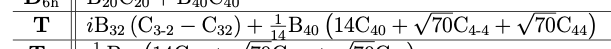

In [1065]:
# l = 1
# realWFs = []
# mixedWFs = []
# for WF in WFs:
#   valence = real_or_imagined(WF)
#   norm = WF.norm()
#   WF = WF*(S(1)/norm)
#   print(valence)
#   if valence == 'r':
#     realWFs.append(WF)
#   elif valence == 'i':
#     realWFs.append(I*WF)
#   elif valence == 'm':
#     mixedWFs.append(WF)
# mixedMs = set()
# for WF in mixedWFs:
#   '''assumption: both m and -m are in there and only as singles'''
#   assert len(WF.dict) == 1
#   for key, val in WF.dict.items():
#     mixedMs.add(abs(key[1]))
# for m in mixedMs:
#   if m%2 == 0:
#     realWFs.append(Qet({(1,m): 1}) + Qet({(1,-m): 1}))
#     realWFs.append(Qet({(1,m): I}) + Qet({(1,-m): -I}))
#   elif m%2 == 1:
#     realWFs.append(Qet({(1,m): I}) + Qet({(1,-m): I}))
#     realWFs.append(Qet({(1,m): 1}) + Qet({(1,-m): -1}))

In [1466]:
for group in CPG.AllGroupLabels:
  print(group)
  for k in range(10):
    print(k,end=',')
    waifus = SymmetryAdaptedWFs(group,k,False,False)
  print('')

C_1
0,1,mixed
mixed
2,mixed
mixed
mixed
mixed
3,mixed
mixed
mixed
mixed
mixed
mixed
4,mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
5,mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
6,mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
7,mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
8,mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
9,mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed

C_i
0,1,2,mixed
mixed
mixed
mixed
3,4,mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
5,6,mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
7,8,mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
mixed
9,
C_2
0,1,2,mixed
mixed
3,mixed
mixed
4,mixed
mixed
mixed
mixed
5,mixed
mixed
mixed
mixed
6,mixed
mixed
mixed
mixed
mixed
mixed
7,mixed
mixed
mixed
mixed
mixed
mixed
8,mixe

In [851]:
for waifu in waifus:
  for k, v in waifu.dict.items():
    l, m = k
    if m<0:
      continue
    if m == 0:
      print(m,N(v))
    else:
      print(m,N(v*sqrt(2)))

6 1.00000000000000
3 1.0*I
0 1.00000000000000


In [676]:
from sympy import N

In [684]:
((waifus[0]).as_ket(True,True))

-|32>/2 + |3\bar{2}>/2

In [688]:
waifus[0]

{(3, -2): 1/2, (3, 2): -1/2}

In [706]:
huh = {1:1,'a':1}

In [776]:
def real_or_imagined(qet):
  '''
  for a given superposition of
  spherical harmonics, determine
  if the total has a pure imaginary (i),
  pure real (r), or mixed character (m),
  it assumes that the coefficients in
  the superposition are all real
  '''
  chunks = dict(qet.dict)
  valences = []
  for key in list(chunks.keys()):
    if key not in chunks.keys():
      continue
    l, m = key
    chunk = chunks[key]
    if (l,-m) in chunks:
      partner = chunks[(l,-m)]
      if abs(partner) == abs(chunk):
        if sign(partner) == sign(chunk):
          if m%2 == 0:
            valences.append("r")
          else:
            valences.append("i")
        else:
          if m%2 == 0:
            valences.append("i")
          else:
            valences.append("r")
      else:
        valences.append("m")
      chunks.pop((l,-m))
    else:
      valences.append("m")
    if m!=0: # if equal to zero this would have been done already
      chunks.pop(key)
  valences = list(set(valences))
  if len(valences) > 1:
    return "m"
  else:
    return valences[0]

# 

In [608]:
WFs, _, vecs = SymmetryAdaptedWFs('O',4)

ValueError: not enough values to unpack (expected 3, got 1)

In [599]:
vecs

((0,), [[5/24, sqrt(70)/24, 5/24]])

In [595]:
linear_independent([[1,1],[0,0],[2,2]])

((0,), [[1, 1]])

In [579]:
Matrix([[1,1],[0,0],[1,-1]]).T

Matrix([
[1, 0,  1],
[1, 0, -1]])

In [580]:
Matrix([[1,1],[0,0],[1,-1]]).T.rref()

(Matrix([
 [1, 0, 0],
 [0, 0, 1]]),
 (0, 2))

In [575]:
vecs.rref()

(Matrix([
 [1, sqrt(70)/5, 1],
 [0,          0, 0],
 [0,          0, 0]]),
 (0,))

In [543]:
SymmetryAdaptedWF('C_3h',3,-3)

{(3, -3): 1}

In [542]:
display(SymmetryAdaptedWF('C_3h',3,-3).as_ket(True, True))

|3\bar{3}>

In [366]:
%%timeit
SymmetryAdaptedWF(CPG.Groups[17], 'A_1',3,-3)

418 µs ± 6.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [367]:
def salc_printer(group_num, lmin, lmax):
    G = group_num
    print('-'*20)
    for irrp in CPG.Groups[G].IrrReps:
        print('SALCs for %s : %s'%(CPG.Groups[G].PointGroupLabel,irrp))
        for ll in np.arange(lmin, lmax+1):
            for mm in np.arange(-ll,ll+0.1):
                mm = int(mm)
                salc = SymmetryAdaptedWF(CPG.Groups[G], irrp, ll, mm)
                if len(salc.dict) == 0:
                    continue
                print('|| l=%d m=%d ||' % (ll,mm), end='')
                display(Latex('$%s$'% latex(salc.as_ket(True,True))))
        print('-'*20)

In [368]:
CPG.Groups[5]

Group:   D_2
Classes: E, C_2`, C_2`, C_2`
Irreps:  A_1, B_1, B_2, B_3

In [370]:
# comparison with BandC Table 2.4 for C3h

In [ ]:
def SymmetryAdaptedWF(Group, IrrRep, l, m):
    # Allows for either string or index input of
    # the irreducible representation
    if isinstance(IrrRep,str):
        IrrIdx = Group.IrrReps.index(IrrRep)
    else:
        IrrIdx = IrrRep
    # Character of the irreducible representation
    chi = Group.CharacterTable[IrrIdx]
    # Degree of the irreducible representation which is the same as
    # the character for the E (identity) element.
    degree = chi[Group.Classes.index('E')]
    # Order of the group which is equal to the sum of the elements
    order = len(Group.Elements)

    SALC = Qet()
    EulerCntr = 0
    for sym in range(len(Group.Classes)):
        for clssze in range(Group.ClassSize[sym]):
            # Get the Euler angles (Z-Y-Z) for each class in the group
            alpha, beta, gamma, detRot = Group.ParameterTable[EulerCntr][:4]
            aRYlm = S(chi[sym])*RYlm(l,m,alpha,beta,gamma,detRot)
            SALC = SALC + aRYlm
            EulerCntr += 1
    SALC = SALC.apply(lambda x,y : (x, simplify(y)))
    
    return (S(degree)/order)*SALC

In [369]:
im = interact_manual(lambda group_num, lmin, lmax: salc_printer(group_num, lmin, lmax),
                group_num=widgets.IntSlider(min=0, max=31, step=1, value=15),
                lmin=widgets.IntSlider(min=0, max=4, step=1, value=3),
                lmax=widgets.IntSlider(min=0, max=4, step=1, value=5));
im.widget.children[-2].description = 'Compute';
display(im);

interactive(children=(IntSlider(value=15, description='group_num', max=31), IntSlider(value=3, description='lm…

<function __main__.<lambda>(group_num, lmin, lmax)>

## Calculation of Crystal Field Potentials

The crystal field potential in a given point group G may be expanded in terms of symmetry adapted functions $f^{A_{1,g}}_{kq}$ obtained by proyecting the $Y_q^k$ spherical harmonics onto the trivial representation $A_{1g}$ of the group. These are the desired proyection given that the potential is a scalar function by definition. 

The $B_{kq}$ are coefficients that depend on radial integrals which may be obtained from fits to experimental data.

$$V_{CF}=\sum_{k=0}^{k=k_\textrm{max}}\sum_{q=-k}^{k}B_{kq} f^{A_{1,g}}_{kq}$$

Let's see how this turns out for group D_3, for kmax = 4

In [1020]:
def GetSALCs(Group,IrrRep,l_max):
    '''
    Function to get all of the symmetry adapted functions for a given
    representation (IrrRep) of a given group (Group) up to a
    maximum l value (l_max)
    '''
    SALCs = []
    for ll in range(1,l_max+1):
        for mm in range(-ll,ll+1):
            SALCs.append(SymmetryAdaptedWF(Group,IrrRep,ll,mm))
    return SALCs

  
def B_CF(ll,mm):
    '''
    Generates a symbol placeholder for the B coefficients
    in the crystal field potential.
    '''
    from sympy import symbols
    if mm<0:
        Bcf = S(-1)**mm*symbols(''.join(['B_',str(ll),str(abs(mm))]), real=True)
    else:
        Bcf = symbols(''.join(['B_',str(ll),str(mm)]), real=True)
    return Bcf

def SubSupSymbol(radix,ll,mm):
    '''
    Generates a symbol placeholder for the B coefficients in the crystal field potential.
    '''
    SubSupSym = symbols(r'{%s}_{%s}^{%s}' % (radix, str(ll), str(mm)))
    return SubSupSym

def SubSubSymbol(radix,ll,mm):
    '''
    Generates a symbol placeholder for the B coefficients in the crystal field potential.
    '''
    SubSubSym = symbols(r'{%s}_{{%s}{%s}}' % (radix, str(ll), str(mm)))
    return SubSubSym
  
def GenerateBList(PointGroupNumber, l):
    Blist = []
    Bcoeff = []
    IdxList = []
    for ll in range(1,l+1):
        for mm in range(-ll,ll+1):
            IdxList.append([ll,mm])
            if PointGroupNumber >= 28:
                if ll == 4 and (abs(mm) == 4):
                    Bcoeff.append(sqrt(S(5)/14))
                    Blist.append(B_CF(ll,0))
                elif ll == 6 and (abs(mm) == 4):
                    Bcoeff.append(sqrt(S(7)/2))
                    Blist.append(B_CF(ll,0))
                else:
                    if mm<0:
                        Bcoeff.append((-1)**mm)
                    else:
                        Bcoeff.append(1)
                    Blist.append(B_CF(ll,abs(mm)))
            else:
                if mm<0:
                    #Bcoeff.append(1) #Jon's Code
                    Bcoeff.append((-1)**mm)
                else:
                    Bcoeff.append(1)
                Blist.append(B_CF(ll,abs(mm)))
    IdxList = np.array(IdxList)
    RepeatIdx = IdxList[:,1]>0
    IdxList = CompareBlist(IdxList)
    IdxList[:,RepeatIdx] = 0
    NormList = IdxList/np.expand_dims(IdxList.sum(axis=0),axis=1).dot(np.ones((1,IdxList.shape[1]))).T
    NormList[np.isnan(NormList)] = 0
    NormList[np.isinf(NormList)] = 0

    Bcoeff = (Bcoeff)
    Blist = (Blist)

    return Bcoeff, Blist, IdxList, NormList

## comparison with BandC for C_{3h}

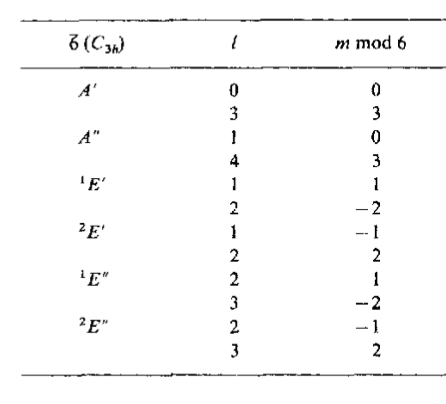

In [433]:
group_index = 21
kmax = 8
VCF = Qet()
salcs = []
for k_index in range(0,kmax+1):
  for q_index in range(-k_index,k_index+1):
    ag = CPG.Groups[group_index].IrrReps[0]
    a_salc = SymmetryAdaptedWF(CPG.Groups[group_index], ag, k_index, q_index)
    if len(a_salc.dict) > 0:
      salcs.append(a_salc)
      VCF = VCF + B_CF(k_index, q_index)*a_salc
ms_n_ls = []
for salc in salcs:
  ms_n_ls.extend(list(salc.dict.keys()))

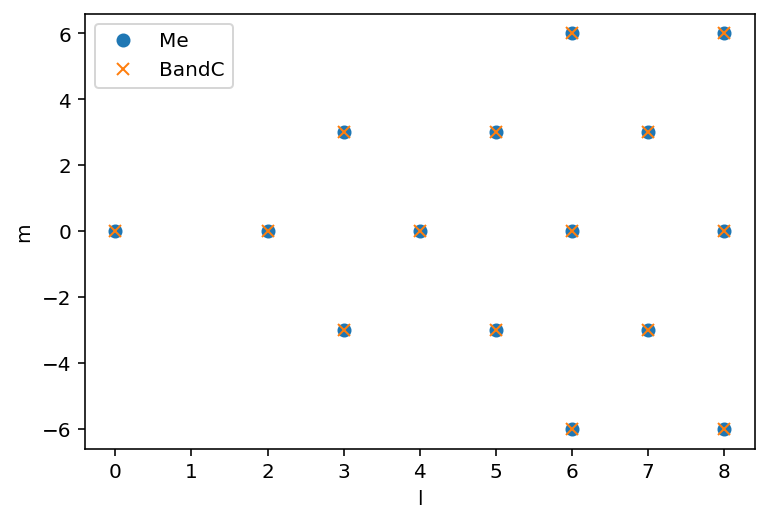

In [434]:
# according to BandC (see above)
bandc = []
for l in range(0,kmax+1,2):
  bandc.extend([(l,m) for m in range(0,l+1,6)])
  bandc.extend([(l,-m) for m in range(0,l+1,6)])
for l in range(3,kmax+1,2):
  bandc.extend([(l,m) for m in range(3,l+1,6)])
  bandc.extend([(l,m) for m in range(3,-l-1,-6)])  
bandc = np.array(list(set(bandc)))
ms_n_ls = np.array(ms_n_ls)
plt.figure()
plt.plot(ms_n_ls[:,0],ms_n_ls[:,1],'o',label='Me')
plt.plot(bandc[:,0],bandc[:,1],'x',label='BandC')
plt.legend()
plt.xlabel('l')
plt.ylabel('m')
plt.show()

## comparison with BandC for D_{2d}

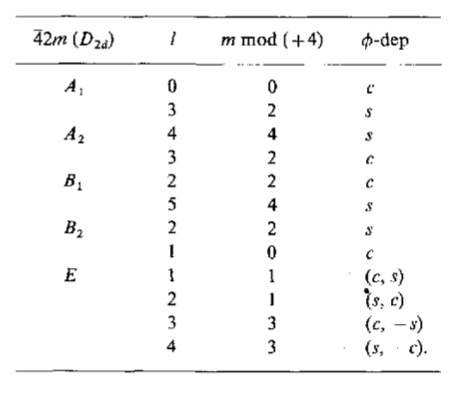

In [429]:
# in these ones there is only m mod(+ x) dependende because the ones that subtract
# give exactly the same ones (or multiples of the same ones)

In [478]:
group_index = 13
kmax = 4
VCF = Qet()
salcs = {}
for k_index in range(0,kmax+1):
  k_salcs = []
  for q_index in range(-k_index,k_index+1):
    ag = CPG.Groups[group_index].IrrReps[0]
    a_salc = SymmetryAdaptedWF(CPG.Groups[group_index], ag, k_index, q_index)
    if len(a_salc.dict) > 0:
      k_salcs.append(a_salc)
      VCF = VCF + B_CF(k_index, q_index)*a_salc
    
    salcs[k_index] = k_salcs
ms_n_ls = []
for key, k_salcs in salcs.items():
  for asalc in k_salcs:
    ms_n_ls.extend(list(asalc.dict.keys()))

In [1021]:
for k in list(salcs.keys()):
  complete_basis = []
  for salc in salcs[k]:
    complete_basis.extend(salc.basis())
  complete_basis = list(set(complete_basis))
  vecs = []
  for salc in salcs[k]:
    vecs.append(salc.vec_in_basis(complete_basis))
  vecs = Matrix(vecs)
  print('l=%d -> %d'% (k,vecs.rank()))

l=0 -> 1
l=1 -> 0
l=2 -> 1
l=3 -> 1
l=4 -> 2


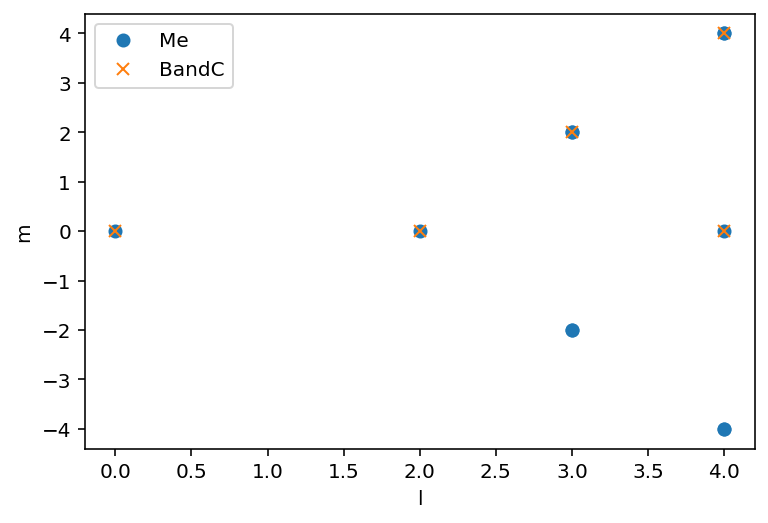

In [1022]:
# according to BandC (see above)
bandc = []
for l in range(0,kmax+1,2):
  bandc.extend([(l,m) for m in range(0,l+1,4)])
for l in range(3,kmax+1,2):
  bandc.extend([(l,m) for m in range(2,l+1,4)])
bandc = np.array(list(set(bandc)))
ms_n_ls = np.array(ms_n_ls)
plt.figure()
plt.plot(ms_n_ls[:,0],ms_n_ls[:,1],'o',label='Me')
plt.plot(bandc[:,0],bandc[:,1],'x',label='BandC')
plt.legend()
plt.xlabel('l')
plt.ylabel('m')
plt.show()

In [768]:
def CompareBlist(Blist):
    len_Blist = len(Blist)
    mask = np.zeros((len_Blist,len_Blist))
    for idx in np.arange(len_Blist):
        mask[idx,:] = (Blist[idx,0]==abs(Blist[:,0]))*(abs(Blist[idx,1])==abs(Blist[:,1]))
    return mask

In [769]:
GenerateBList(18,4)

/Users/juan/opt/anaconda3/envs/qdef/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


([-1.0,
  1,
  1,
  1.0,
  -1.0,
  1,
  1,
  1,
  -1.0,
  1.0,
  -1.0,
  1,
  1,
  1,
  1,
  1.0,
  -1.0,
  1.0,
  -1.0,
  1,
  1,
  1,
  1,
  1],
 [B_11,
  B_10,
  B_11,
  B_22,
  B_21,
  B_20,
  B_21,
  B_22,
  B_33,
  B_32,
  B_31,
  B_30,
  B_31,
  B_32,
  B_33,
  B_44,
  B_43,
  B_42,
  B_41,
  B_40,
  B_41,
  B_42,
  B_43,
  B_44],
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.,

In [770]:
GetSALCs(CPG.Groups[17],'A_1',4)

[{},
 {},
 {},
 {},
 {},
 {(2, 0): 1},
 {},
 {},
 {(3, -3): 1/2, (3, 3): -1/2},
 {},
 {},
 {},
 {},
 {},
 {(3, 3): 1/2, (3, -3): -1/2},
 {},
 {(4, -3): 1/2, (4, 3): 1/2},
 {},
 {},
 {(4, 0): 1},
 {},
 {},
 {(4, 3): 1/2, (4, -3): 1/2},
 {}]

In [718]:
def CFrow(grp, l):
    '''
    This function takes the index grp for a crystallographic point group
    and a value for the angular momentum number l
    and returns a formatted latex string for the corresponding
    crystal field function.
    '''
    row = []
    SALCs = GetSALCs(CPG.Groups[grp],0,l)
    if len(CPG.Groups[grp].PointGroupLabel.split('_'))>1:
        row.append(''.join(['_{'.join(CPG.Groups[grp].PointGroupLabel.split('_')),'}']))
    else:
        row.append(CPG.Groups[grp].PointGroupLabel)
    
    Bcoeff, Blist, IdxList, NormList = GenerateBList(CPG.Groups[grp].PointGroupNumber, l)
    
    Sym_SALCs = SALC_SymTest(Bcoeff*SALCs).dot(IdxList)
    Real_SALCs = RealCheck((Sym_SALCs).dot(IdxList))
        
    V_CF = (Sym_SALCs*Real_SALCs).dot(Blist.dot(NormList))
    
    CoeffDict = V_CF.as_coefficients_dict()
    Vcf_tmp = 0
    for coeff in CoeffDict.keys():
        if abs(CoeffDict[coeff])<1e-7:
            CoeffDict[coeff] = 0
        Vcf_tmp = Vcf_tmp + CoeffDict[coeff]*coeff
    
    row.append(latex(Vcf_tmp))

    return row

[0]